<a href="https://colab.research.google.com/github/c-etulle/Vegetation-dynamics-in-the-Subandean-grasslands-of-Chubut/blob/main/7_Correlation_%26_Z_Values_for_NDVI_and_SPEI_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Set-Up

In [ ]:
!pip install rasterio
%pip install unidecode

import glob
import os
import numpy as np
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
import geopandas as gpd
from google.colab import drive
import os, sys
import time
import fnmatch
import ee
import plotly.graph_objs as go
import plotly.express as px
from scipy import stats
import rasterio
import re
from unidecode import unidecode
from scipy.stats import zscore

drive.mount('/content/drive')
%cd /content/drive/My\ Drive/ee-meinzinger-patagonia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.0 MB/s eta 0:00:00
Mounted at /content/drive
/content/drive/My Drive/ee-meinzinger-patagonia


In [ ]:
# Create a list of faulty SPEI locations
faulty_locations = [
    "Cerro Condor",
    "La Clara",
    "Berna",
    "Bahia Cracker",
    "Valdes Creek Secc La Adela",
    "La Esperanza Biedma"
]

# Test
print(faulty_locations)

['Cerro Condor', 'La Clara', 'Berna', 'Bahia Cracker', 'Valdes Creek Secc La Adela', 'La Esperanza Biedma']


## 1.1) Get NDVI-data from LS

In [ ]:
path = "Data/landsat-2000-2024"

# find all the files that end with '_NDVI.csv'
csv_files = glob.glob(os.path.join(path, '*_NDVI.csv'))

# test
print(csv_files)

['Data/landsat-2000-2024/La Ana_NDVI.csv', 'Data/landsat-2000-2024/CERM_NDVI.csv', 'Data/landsat-2000-2024/Alto Rio Mayo_NDVI.csv', 'Data/landsat-2000-2024/1 San Felipe_NDVI.csv', 'Data/landsat-2000-2024/Cerro Condor_NDVI.csv', 'Data/landsat-2000-2024/2 San Felipe_NDVI.csv', 'Data/landsat-2000-2024/La Isabel_NDVI.csv', 'Data/landsat-2000-2024/La Clara_NDVI.csv', 'Data/landsat-2000-2024/Berna_NDVI.csv', 'Data/landsat-2000-2024/Las Piedritas_NDVI.csv', 'Data/landsat-2000-2024/Bahia Cracker_NDVI.csv', 'Data/landsat-2000-2024/San Sebastian_NDVI.csv', 'Data/landsat-2000-2024/Bella Vista_NDVI.csv', 'Data/landsat-2000-2024/La Regina_NDVI.csv', 'Data/landsat-2000-2024/La Payanca_NDVI.csv', 'Data/landsat-2000-2024/Los 5 Hermanos_NDVI.csv', 'Data/landsat-2000-2024/Cerco de Piedras_NDVI.csv', 'Data/landsat-2000-2024/Chacra Berwyn_NDVI.csv', 'Data/landsat-2000-2024/El Moro_NDVI.csv', 'Data/landsat-2000-2024/1 San Jose_NDVI.csv', 'Data/landsat-2000-2024/Don Julian_NDVI.csv', 'Data/landsat-2000-2024

In [ ]:
## Read all csv-files and combine them into one df

# Make a placeholder-list
df_list = []

# Loop through the list of csv-files and read them into dfs
for file in csv_files:
  df = pd.read_csv(file)
  df['Area'] = file # make a new column in the individual df
  df_list.append(df) # indivial dfs are getting "added together"

# Concatenate all dfs into a single df
combined_df = pd.concat(df_list, ignore_index=True)

# Remove random column called .geo
combined_df = combined_df.drop('.geo', axis=1)

# Remove suffix, since it is the same in all of them
combined_df['Area'] = combined_df['Area'].str.replace("_NDVI.csv", '', regex=False)

# Remove prefix "landsat-2000-2024"/ from 'Area' column
combined_df['Area'] = combined_df['Area'].str.replace("landsat-2000-2024/", '', regex=False)

# Remove prefix "Data/" from the 'Area' column
combined_df['Area'] = combined_df['Area'].str.replace("Data/", '', regex=False)

# Re-scale NDVI-values
combined_df['NDVI'] = combined_df['NDVI']/10000

# Define month & year as int
combined_df['year'] = combined_df['year'].astype(int)
combined_df['month'] = combined_df['month'].astype(int)

# Adds a column called year_month
combined_df['year_month'] = combined_df['year'].astype(str) + '_' + combined_df['month'].apply(lambda x: f"{x:02d}") #puts a 0 in front of all the months until september

# Show only header
combined_df.head()

,system:index,NDVI,month,year,Area,year_month
0,0,0.0692,1,2000,La Ana,2000_01
1,1,0.0552,2,2000,La Ana,2000_02
2,2,0.0491,3,2000,La Ana,2000_03
3,3,0.0460,4,2000,La Ana,2000_04
4,4,0.0215,5,2000,La Ana,2000_05


In [ ]:
## Restructure to wide format
pivot_df = combined_df.pivot_table(
    index = 'year_month',
    columns = 'Area',
    values = 'NDVI'
)

# Remove faulty locations
pivot_df = pivot_df.drop(columns=faulty_locations)

#pivot_df = pivot_df.reset_index()

pivot_df

Area,1 Rio Guenguel,1 San Felipe,1 San Jose,2 Rio Guenguel,2 San Felipe,2 San Jose,Aguada Amarga,Alto Rio Mayo,Arabia Saudita,Arregui,...,Nueva Lubecka,Numancia,Quichaura,Rancho Grande,San Sebastian,Seis Hermanos,Telleriarte,Tureo,Valdes Creek Secc. El Piquillin,Yague
year_month,,,,,,,,,,,,,,,,,,,,,
2000_01,0.04255,0.06080,0.03650,0.0526,0.05820,0.08450,0.08400,0.07920,NaN,0.04010,...,0.0429,0.0741,0.05905,0.03380,0.04910,0.03310,0.08450,0.03510,0.0797,0.07260
2000_02,0.04015,0.06640,0.03950,0.0565,0.05910,0.07930,0.08550,NaN,0.06325,0.03990,...,0.0418,NaN,0.04670,0.03190,0.04040,0.03770,0.07215,0.02610,NaN,0.06585
2000_03,0.03890,0.07040,0.03260,0.0569,NaN,0.08210,0.08020,0.06410,0.05335,0.04370,...,0.0421,0.0685,0.04705,0.03425,0.04740,0.03325,0.07170,0.03220,0.0710,0.06485
2000_04,0.04640,0.06290,0.04390,0.0465,0.06400,0.06845,NaN,0.06290,0.04770,0.04380,...,0.0416,0.0803,0.04360,0.02880,0.02995,0.03280,0.06770,0.04200,NaN,0.05770
2000_05,NaN,0.07825,0.06170,NaN,0.06790,0.06910,NaN,NaN,0.05985,0.05120,...,0.0456,NaN,0.03910,NaN,0.04830,0.03950,0.05060,0.04100,0.0871,0.06010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024_05,0.05675,0.07730,0.04815,0.0601,0.08025,0.08775,0.07970,0.08085,0.08130,0.05405,...,0.0594,0.1061,0.05875,0.04625,0.06095,0.04895,0.08390,0.04940,0.0964,0.08050
2024_06,NaN,0.08035,0.05020,NaN,0.08360,0.08810,0.07910,NaN,NaN,0.04510,...,0.0939,NaN,NaN,NaN,0.07600,NaN,0.08420,0.03115,0.0865,0.07410
2024_07,0.04660,0.07710,0.04800,0.0468,0.08095,0.07360,0.07445,0.07010,0.07730,0.05565,...,0.0617,0.0950,0.05290,0.04420,0.06390,0.04090,0.07420,0.04270,0.1210,0.06755


## 1.2) Get SPEI-data

### a.) Import SPEI .csv files

In [ ]:
# Import spei.csv files
file_path = 'pts_drought.csv'
spei_data = pd.read_csv(file_path)

# Drop the first two columns
# spei_data = spei_data.drop(spei_data.columns[[0, 1]], axis=1)

# Print df
spei_data

,Site_Name,200001,200002,200003,200004,200005,200006,200007,200008,200009,...,202203,202204,202205,202206,202207,202208,202209,202210,202211,202212
0,CERM,-0.813071,-0.531295,-0.411697,0.126315,0.385927,0.271689,0.160641,-0.461901,0.387128,...,-0.688510,-0.074080,-0.142551,-0.032422,-0.190797,-0.684662,-0.405283,-0.932429,-0.975499,-0.391333
1,La Ana,-0.783111,-0.504406,-0.385948,0.160207,0.428115,0.331130,0.237738,-0.381703,0.507103,...,-0.637496,0.012185,-0.011638,0.096884,-0.080303,-0.581716,-0.294664,-0.866399,-0.933547,-0.367457
2,Media Luna,-1.649658,-1.542279,-1.221749,-0.686897,-0.908912,-1.164397,-1.288085,-1.529917,-1.457009,...,-0.090564,-0.031873,-0.149154,-0.109004,-0.169331,-0.461367,-0.330441,-0.650096,-0.856630,-0.055589
3,Alto Río Mayo,-1.531504,-1.394958,-1.075082,-0.491075,-0.694021,-0.984798,-1.168768,-1.467488,-1.346866,...,-0.227511,-0.127341,-0.208958,-0.167885,-0.114212,-0.459518,-0.336057,-0.659154,-0.881930,-0.111790
4,1 San Felipe,0.855075,1.536438,1.433884,1.094649,0.759859,1.166212,1.395803,0.806848,1.552023,...,0.342742,0.801215,0.216013,-0.086819,-0.187533,-0.508537,0.479347,0.294409,0.780236,0.815613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,LAS MERCEDES,-1.793581,-1.294555,-0.914356,-0.422300,-0.361510,-0.406663,-0.571249,-0.785246,-0.680681,...,-0.271087,0.186832,0.149851,0.114713,0.339374,0.026502,0.322859,-0.139787,-0.307518,0.168421
99,Nueva Lubecka,-0.955758,-0.708613,-0.629381,-0.345823,-0.125787,-0.039212,-0.198000,-0.441106,0.149731,...,-0.775765,0.196906,0.256400,0.394478,0.963317,0.685902,1.152332,0.462181,0.251687,0.409156
100,El Poyo,-0.054394,0.199040,-0.220528,0.028710,-0.134944,0.278674,0.003481,-0.498608,-0.085466,...,0.631636,1.199767,0.930407,1.143589,1.446969,0.955994,1.372802,0.705379,0.747518,0.600688
101,El Saucal,0.461740,0.509877,0.011568,0.144197,-0.021402,0.721525,0.588717,0.400964,1.073138,...,0.432646,0.881466,0.735258,0.491094,0.514745,-0.036807,0.432191,0.122619,0.251893,0.442854


### b.) Restructering of df

In [ ]:
## Restructuring the df

# Function to transform the column names, so instead of "YYYYMM", you get "YYYY_MM"
def transform_column_name(col_name):
    if col_name.isdigit() and len(col_name) == 6:
        return col_name[:4] + "_" + col_name[4:]
    return col_name

# Apply the transformation to the columns
spei_data.columns = [transform_column_name(col) for col in spei_data.columns]

# Set 'Site_Name' as the index and then transpose the DataFrame
spei_data = spei_data.set_index('Site_Name').transpose()

# Function to clean site names: remove (, ), and °, and normalize special characters
def clean_site_name(site_name):
    # Remove (, ), and °
    site_name = re.sub(r'[()°]', '', site_name)
    # Convert special characters to their closest ASCII equivalents
    site_name = unidecode(site_name)
    return site_name

# Apply the cleaning function to the column names
spei_data.columns = [clean_site_name(col) for col in spei_data.columns]

# Remove duplicates (San Felipe & San José)
# spei_data = spei_data.loc[:, ~spei_data.columns.duplicated()]
# spei_data.head(12)

# Remove faulty locations
spei_data = spei_data.drop(columns=faulty_locations)
spei_data

,CERM,La Ana,Media Luna,Alto Rio Mayo,1 San Felipe,2 San Felipe,La Isabel,Las Piedritas,San Sebastian,Bella Vista,...,Entre Sierras,Don Pablo,Don Silveiro,Telleriarte,Arregui,LAS MERCEDES,Nueva Lubecka,El Poyo,El Saucal,Lino
2000_01,-0.813071,-0.783111,-1.649658,-1.531504,0.855075,0.876858,0.631327,0.867979,0.694931,0.709893,...,-0.291129,-1.282630,-1.376483,-0.079836,-0.052461,-1.793581,-0.955758,-0.054394,0.461740,-0.169275
2000_02,-0.531295,-0.504406,-1.542279,-1.394958,1.536438,1.563936,1.427498,1.161941,0.860527,0.862821,...,0.153957,-0.799287,-0.990582,0.065935,-0.166728,-1.294555,-0.708613,0.199040,0.509877,0.012208
2000_03,-0.411697,-0.385948,-1.221749,-1.075082,1.433884,1.458879,1.177074,0.522698,0.358984,0.435837,...,-0.346401,-1.009522,-0.935905,-0.315831,-0.669384,-0.914356,-0.629381,-0.220528,0.011568,-0.313835
2000_04,0.126315,0.160207,-0.686897,-0.491075,1.094649,1.121021,0.714530,0.553617,-0.249447,-0.210142,...,-0.174535,-0.694982,-0.712200,-0.118661,-0.509206,-0.422300,-0.345823,0.028710,0.144197,-0.108531
2000_05,0.385927,0.428115,-0.908912,-0.694021,0.759859,0.785934,0.635349,0.116658,-0.190671,-0.200584,...,-0.068714,-0.584317,-0.482774,-0.523627,-0.708436,-0.361510,-0.125787,-0.134944,-0.021402,-0.508085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022_08,-0.684662,-0.581716,-0.461367,-0.459518,-0.508537,-0.466543,-0.448080,-0.227330,0.308702,0.185396,...,0.614547,1.269229,1.220579,1.018303,0.086792,0.026502,0.685902,0.955994,-0.036807,1.366251
2022_09,-0.405283,-0.294664,-0.330441,-0.336057,0.479347,0.502651,0.614624,0.354288,0.802871,0.719943,...,0.813067,1.467445,1.484851,1.695424,0.553442,0.322859,1.152332,1.372802,0.432191,1.942673
2022_10,-0.932429,-0.866399,-0.650096,-0.659154,0.294409,0.315152,0.294304,0.368691,0.618560,0.547265,...,0.331688,1.049364,0.839481,0.963435,0.180794,-0.139787,0.462181,0.705379,0.122619,1.278696
2022_11,-0.975499,-0.933547,-0.856630,-0.881930,0.780236,0.747667,0.643536,0.912110,0.746615,0.671949,...,0.364426,0.997796,0.769348,1.396273,0.484491,-0.307518,0.251687,0.747518,0.251893,1.495972


## 1.3) Get MODIS NDVI

Note CME: Here I import the .csv files

The data format is already the long format, but has too many columns, and different naming. This is fixed here.

In [ ]:
path_modis = "Data/modis-2000-2024"

# find all the files that end with '_NDVI.csv'
csv_files_modis = glob.glob(os.path.join(path_modis, '*_NDVI.csv'))

print(csv_files_modis)

## Read all csv-files and combine them into one df

# Make a placeholder-list
df_list_modis = []

# Loop through the list of csv-files and read them into dfs
for file in csv_files_modis:
  df = pd.read_csv(file)
  df['Area'] = file # make a new column in the individual df
  df_list_modis.append(df) # indivial dfs are getting "added together"

# Concatenate all dfs into a single df
combined_df_modis = pd.concat(df_list_modis, ignore_index=True)

# Remove random column called .geo
combined_df_modis = combined_df_modis.drop('.geo', axis=1)

# Remove suffix, since it is the same in all of them
combined_df_modis['Area'] = combined_df_modis['Area'].str.replace("_NDVI.csv", '', regex=False)

# Remove prefix, since it is the same in all of them
combined_df_modis['Area'] = combined_df_modis['Area'].str.replace("Data/modis-2000-2024/", '', regex=False)

# Re-scale NDVI-values
combined_df_modis['NDVI'] = combined_df_modis['NDVI']/10000

# Define month & year as int
combined_df_modis['year'] = combined_df_modis['year'].astype(int)
combined_df_modis['month'] = combined_df_modis['month'].astype(int)

# Adds a column called year_month
combined_df_modis['year_month'] = combined_df_modis['year'].astype(str) + '_' + combined_df_modis['month'].apply(lambda x: f"{x:02d}") #puts a 0 in front of all the months until september

# Show only header
combined_df_modis.head()

# Restructure to match the other two datasets (keep the long format)
# Select only the relevant columns from the MODIS data
combined_df_modis = combined_df_modis[['year_month', 'Area', 'NDVI']]

# Step 2: Rename the columns
combined_df_modis = combined_df_modis.rename(columns={'Area': 'Site_Name', 'NDVI': 'NDVI_modis'})

# The resulting dataframe will now only contain 'year_month', 'site_name', and 'NDVI_modis'
print(combined_df_modis)

['Data/modis-2000-2024/CERM_NDVI.csv', 'Data/modis-2000-2024/Alto Rio Mayo_NDVI.csv', 'Data/modis-2000-2024/1 San Felipe_NDVI.csv', 'Data/modis-2000-2024/2 San Felipe_NDVI.csv', 'Data/modis-2000-2024/Cerro Condor_NDVI.csv', 'Data/modis-2000-2024/La Clara_NDVI.csv', 'Data/modis-2000-2024/Las Piedritas_NDVI.csv', 'Data/modis-2000-2024/La Isabel_NDVI.csv', 'Data/modis-2000-2024/Berna_NDVI.csv', 'Data/modis-2000-2024/San Sebastian_NDVI.csv', 'Data/modis-2000-2024/Bella Vista_NDVI.csv', 'Data/modis-2000-2024/La Regina_NDVI.csv', 'Data/modis-2000-2024/Bahia Cracker_NDVI.csv', 'Data/modis-2000-2024/Chacra Berwyn_NDVI.csv', 'Data/modis-2000-2024/La Payanca_NDVI.csv', 'Data/modis-2000-2024/Los 5 Hermanos_NDVI.csv', 'Data/modis-2000-2024/Cerco de Piedras_NDVI.csv', 'Data/modis-2000-2024/Don Julian_NDVI.csv', 'Data/modis-2000-2024/2 San Jose_NDVI.csv', 'Data/modis-2000-2024/El Moro_NDVI.csv', 'Data/modis-2000-2024/1 San Jose_NDVI.csv', 'Data/modis-2000-2024/Cerro Toro_NDVI.csv', 'Data/modis-2000-

## 1.4) Get Cluster

In [ ]:
# Load the cluster_df into script
cluster_df = pd.read_csv('cluster_df.csv')

# Now you can use cluster_df in this new script
print(cluster_df.head())

        Site_Name  cluster
0  1 Rio Guenguel        1
1    1 San Felipe        2
2      1 San Jose        2
3  2 Rio Guenguel        1
4    2 San Felipe        2


# 2.) Checking that the column names of SPEI and Landsat data frames are identical

In [ ]:
# Find columns in df1 (pts_drought_copy) but not in df2 (pivot_df)
columns_in_df1_not_in_df2 = set(spei_data.columns) - set(pivot_df.columns)

# Find columns in df2 but not in df1
columns_in_df2_not_in_df1 = set(pivot_df.columns) - set(spei_data.columns)

# Output the results
if not columns_in_df1_not_in_df2 and not columns_in_df2_not_in_df1:
    print("The column names of Landsat and SPEI are identical.")
else:
    if columns_in_df1_not_in_df2:
        print("Columns in df1 but not in df2:", columns_in_df1_not_in_df2)
    if columns_in_df2_not_in_df1:
        print("Columns in df2 but not in df1:", columns_in_df2_not_in_df1)


The column names of Landsat and SPEI are identical.


# 3.) Convert both dfs to long format with the melt function and merge

## 3.1) NDVI data

In [ ]:
pivot_df_reset = pivot_df.reset_index().rename(columns={'index': 'year_month'})

NDVI_long = pd.melt(pivot_df_reset, id_vars=['year_month'], var_name='Site_Name', value_name='NDVI')

NDVI_long

,year_month,Site_Name,NDVI
0,2000_01,1 Rio Guenguel,0.04255
1,2000_02,1 Rio Guenguel,0.04015
2,2000_03,1 Rio Guenguel,0.03890
3,2000_04,1 Rio Guenguel,0.04640
4,2000_05,1 Rio Guenguel,NaN
...,...,...,...
28610,2024_05,Yague,0.08050
28611,2024_06,Yague,0.07410
28612,2024_07,Yague,0.06755
28613,2024_08,Yague,0.06945


## 3.2) SPEI data

In [ ]:
SPEI_df_reset = spei_data.reset_index().rename(columns={'index': 'year_month'})

SPEI_long = pd.melt(SPEI_df_reset, id_vars=['year_month'], var_name='Site_Name', value_name='SPEI')

SPEI_long

,year_month,Site_Name,SPEI
0,2000_01,CERM,-0.813071
1,2000_02,CERM,-0.531295
2,2000_03,CERM,-0.411697
3,2000_04,CERM,0.126315
4,2000_05,CERM,0.385927
...,...,...,...
26767,2022_08,Lino,1.366251
26768,2022_09,Lino,1.942673
26769,2022_10,Lino,1.278696
26770,2022_11,Lino,1.495972


## 3.3) Merge the two dfs

In [ ]:
# Perform an inner merge to keep only the matching rows in both DataFrames (there are more NDVI-values than SPEI-values)
NDVI_SPEI_merged = pd.merge(NDVI_long, SPEI_long, on=['Site_Name', 'year_month'], how='inner')

NDVI_SPEI_merged

,year_month,Site_Name,NDVI,SPEI
0,2000_01,1 Rio Guenguel,0.04255,-1.202183
1,2000_02,1 Rio Guenguel,0.04015,-0.862369
2,2000_03,1 Rio Guenguel,0.03890,-0.742418
3,2000_04,1 Rio Guenguel,0.04640,-0.189822
4,2000_05,1 Rio Guenguel,NaN,-0.093864
...,...,...,...,...
26573,2022_08,Yague,0.07060,1.864572
26574,2022_09,Yague,0.06310,2.043146
26575,2022_10,Yague,0.08110,1.792258
26576,2022_11,Yague,0.08780,1.636023


## 3.4) Add the MODIS NDVI data as well

Important here: In this dataframe, only the dates that are found in all three datasets are kept!

In [ ]:
# Perform an inner merge to keep only the matching rows in both DataFrames (there are more NDVI-values than SPEI-values)
NDVI_SPEI_merged = pd.merge(NDVI_long, SPEI_long, on=['Site_Name', 'year_month'], how='inner')

Two_NDVI_SPEI_merged = pd.merge(NDVI_SPEI_merged, combined_df_modis, on=['Site_Name', 'year_month'], how='inner')

# Calculate z-scores for each column and add them as new columns
Two_NDVI_SPEI_merged['zscore_NDVI'] = (Two_NDVI_SPEI_merged['NDVI'] - Two_NDVI_SPEI_merged['NDVI'].mean()) / Two_NDVI_SPEI_merged['NDVI'].std()
Two_NDVI_SPEI_merged['zscore_SPEI'] = (Two_NDVI_SPEI_merged['SPEI'] - Two_NDVI_SPEI_merged['SPEI'].mean()) / Two_NDVI_SPEI_merged['SPEI'].std()
Two_NDVI_SPEI_merged['zscore_NDVI_modis'] = (Two_NDVI_SPEI_merged['NDVI_modis'] - Two_NDVI_SPEI_merged['NDVI_modis'].mean()) / Two_NDVI_SPEI_merged['NDVI_modis'].std()

Two_NDVI_SPEI_merged.head(5)

,year_month,Site_Name,NDVI,SPEI,NDVI_modis,zscore_NDVI,zscore_SPEI,zscore_NDVI_modis
0,2000_01,1 Rio Guenguel,0.04255,-1.202183,NaN,-1.153345,-1.183768,NaN
1,2000_02,1 Rio Guenguel,0.04015,-0.862369,0.14080,-1.269029,-0.814081,-0.738900
2,2000_03,1 Rio Guenguel,0.03890,-0.742418,0.13175,-1.329281,-0.683586,-0.877443
3,2000_04,1 Rio Guenguel,0.04640,-0.189822,0.14920,-0.967770,-0.082413,-0.610307
4,2000_05,1 Rio Guenguel,NaN,-0.093864,0.13650,NaN,0.021980,-0.804727


## 3.5) Add the clusters

In [ ]:
# Perform an inner merge to keep only the matching rows in both DataFrames (NDVI_long and SPEI_long)
NDVI_SPEI_merged = pd.merge(NDVI_long, SPEI_long, on=['Site_Name', 'year_month'], how='inner')

# Merge NDVI_SPEI_merged with combined_df_modis on 'Site_Name' and 'year_month'
Two_NDVI_SPEI_merged = pd.merge(NDVI_SPEI_merged, combined_df_modis, on=['Site_Name', 'year_month'], how='inner')

# Merge Two_NDVI_SPEI_merged with cluster_df on 'Site_Name'
Two_NDVI_SPEI_cluster_merged = pd.merge(Two_NDVI_SPEI_merged, cluster_df, on='Site_Name', how='inner')

# Calculate z-scores for each column and add them as new columns
Two_NDVI_SPEI_cluster_merged['zscore_NDVI'] = (Two_NDVI_SPEI_cluster_merged['NDVI'] - Two_NDVI_SPEI_cluster_merged['NDVI'].mean()) / Two_NDVI_SPEI_cluster_merged['NDVI'].std()
Two_NDVI_SPEI_cluster_merged['zscore_SPEI'] = (Two_NDVI_SPEI_cluster_merged['SPEI'] - Two_NDVI_SPEI_cluster_merged['SPEI'].mean()) / Two_NDVI_SPEI_cluster_merged['SPEI'].std()
Two_NDVI_SPEI_cluster_merged['zscore_NDVI_modis'] = (Two_NDVI_SPEI_cluster_merged['NDVI_modis'] - Two_NDVI_SPEI_cluster_merged['NDVI_modis'].mean()) / Two_NDVI_SPEI_cluster_merged['NDVI_modis'].std()

# Display the first 5 rows of the final merged dataframe
Two_NDVI_SPEI_cluster_merged.head(5)



,year_month,Site_Name,NDVI,SPEI,NDVI_modis,cluster,zscore_NDVI,zscore_SPEI,zscore_NDVI_modis
0,2000_01,1 Rio Guenguel,0.04255,-1.202183,NaN,1,-1.153345,-1.183768,NaN
1,2000_02,1 Rio Guenguel,0.04015,-0.862369,0.14080,1,-1.269029,-0.814081,-0.738900
2,2000_03,1 Rio Guenguel,0.03890,-0.742418,0.13175,1,-1.329281,-0.683586,-0.877443
3,2000_04,1 Rio Guenguel,0.04640,-0.189822,0.14920,1,-0.967770,-0.082413,-0.610307
4,2000_05,1 Rio Guenguel,NaN,-0.093864,0.13650,1,NaN,0.021980,-0.804727


# 4.) Correlations for SPEI vs NDVI

## 4.1) Correlation across all dates and all sites

**Note:** Pearson's correlation coefficient:


*   Ranges from −1 to 1
*   1 implies that a linear equation describes the relationship between X and Y perfectly (all data points on a line)
*   0 implies no linear dependency



### 4.1.1) **Without** averaging

#### a.) Calculate correlation

In [ ]:
# Calculate Pearson correlation between 'SPEI' and 'NDVI'
correlation = NDVI_SPEI_merged['SPEI'].corr(NDVI_SPEI_merged['NDVI'], method='pearson')

# Display the result
print("Pearson correlation between SPEI and NDVI:", correlation)

Pearson correlation between SPEI and NDVI: 0.09011908879937064


#### b.) Plot correlation

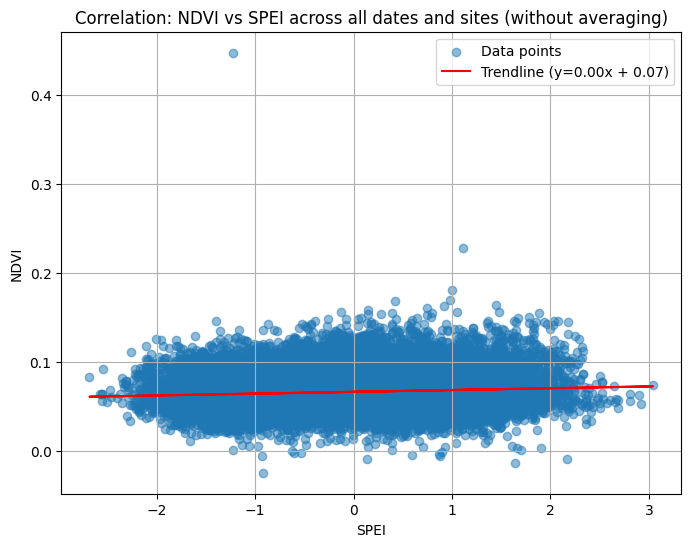

In [ ]:
# Remove rows with NA values in 'SPEI' or 'NDVI' (otherwise trendline does not appear)
NDVI_SPEI_cleaned = NDVI_SPEI_merged.dropna(subset=['SPEI', 'NDVI'])

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(NDVI_SPEI_cleaned['SPEI'], NDVI_SPEI_cleaned['NDVI'], alpha=0.5, label='Data points')

# Calculate the line of best fit (linear regression)
slope, intercept = np.polyfit(NDVI_SPEI_cleaned['SPEI'], NDVI_SPEI_cleaned['NDVI'], 1)
trendline = slope * NDVI_SPEI_cleaned['SPEI'] + intercept

# Plot the trendline
plt.plot(NDVI_SPEI_cleaned['SPEI'], trendline, color='red', label=f'Trendline (y={slope:.2f}x + {intercept:.2f})')

# Add title and labels
plt.title('Correlation: NDVI vs SPEI across all dates and sites (without averaging)')
plt.xlabel('SPEI')
plt.ylabel('NDVI')

# Add legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

### 4.1.2) **With** averaging

#### a.) Getting first the average


In [ ]:
# Group by 'year_month' and calculate the mean for 'NDVI' and 'SPEI'
NDVI_SPEI_mean = NDVI_SPEI_merged.groupby('year_month')[['NDVI', 'SPEI']].mean().reset_index()

# Display the resulting DataFrame
print(NDVI_SPEI_mean)

    year_month      NDVI      SPEI
0      2000_01  0.059840 -0.092331
1      2000_02  0.055493  0.156698
2      2000_03  0.056140 -0.077749
3      2000_04  0.053255 -0.015340
4      2000_05  0.053921 -0.074739
..         ...       ...       ...
269    2022_08  0.062326  0.192933
270    2022_09  0.068128  0.635901
271    2022_10  0.078940  0.198400
272    2022_11  0.087535  0.301011
273    2022_12  0.084114  0.428274

[274 rows x 3 columns]


#### b.) Calculate correlation

In [ ]:
# Calculate Pearson correlation between 'SPEI' and 'NDVI'
correlation_mean = NDVI_SPEI_mean['SPEI'].corr(NDVI_SPEI_mean['NDVI'], method='pearson')

# Display the result
print("Pearson correlation between SPEI and NDVI:", correlation_mean)

Pearson correlation between SPEI and NDVI: 0.10196186625263969


#### c.) Plot correlation

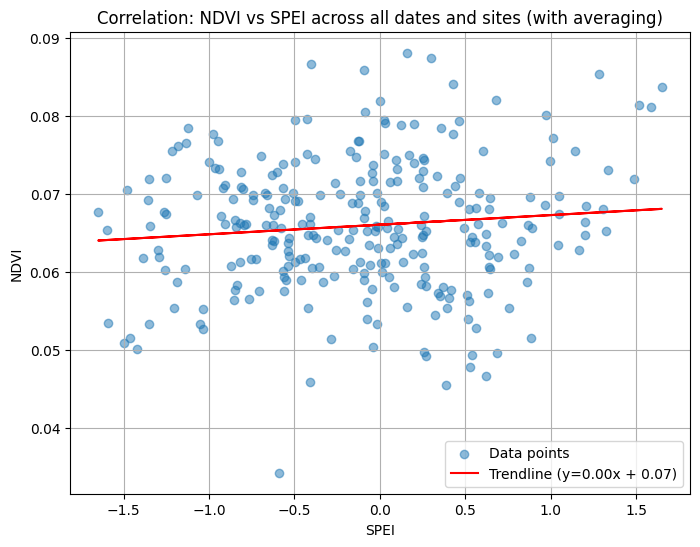

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(NDVI_SPEI_mean['SPEI'], NDVI_SPEI_mean['NDVI'], alpha=0.5, label='Data points')

# Calculate the line of best fit (linear regression)
slope, intercept = np.polyfit(NDVI_SPEI_mean['SPEI'], NDVI_SPEI_mean['NDVI'], 1)
trendline = slope * NDVI_SPEI_mean['SPEI'] + intercept

# Plot the trendline
plt.plot(NDVI_SPEI_mean['SPEI'], trendline, color='red', label=f'Trendline (y={slope:.2f}x + {intercept:.2f})')

# Add title and labels
plt.title('Correlation: NDVI vs SPEI across all dates and sites (with averaging)')
plt.xlabel('SPEI')
plt.ylabel('NDVI')

# Add legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## 4.2) Correlation for each site

### a.) Calculate correlation

In [ ]:
# Function to calculate Pearson correlation for each group
def calculate_pearson(group):
    return group['NDVI'].corr(group['SPEI'])

# Group by 'Site_Name' and calculate the Pearson correlation
correlation_df = NDVI_SPEI_merged.groupby('Site_Name').apply(calculate_pearson).reset_index()

# Rename the columns for clarity
correlation_df.columns = ['Site_Name', 'Pearson_Correlation']

# Display the resulting DataFrame
#print(correlation_df)

# Sort the DataFrame by the 'Pearson_Correlation' column in descending order
correlation_df_sorted = correlation_df.sort_values(by='Pearson_Correlation', ascending=False).reset_index(drop=True)

# Display the sorted DataFrame
print(correlation_df_sorted)

           Site_Name  Pearson_Correlation
0      Aguada Amarga             0.382235
1   Cerco de Piedras             0.309587
2         Don Julian             0.290370
3           El Oasis             0.289187
4     Canadon Blanco             0.282873
..               ...                  ...
92         La Cancha            -0.123681
93         El Bosque            -0.125090
94        El Rosillo            -0.126215
95    1 Rio Guenguel            -0.133280
96         El Mollar            -0.292181

[97 rows x 2 columns]


<ipython-input-21-5114ea4733a3>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_df = NDVI_SPEI_merged.groupby('Site_Name').apply(calculate_pearson).reset_index()


### b.) Plotting regressions for selected locations

Note: Chali Aike (Andesregion), El Oasis (coast) and San Sebastián (in the land inner)

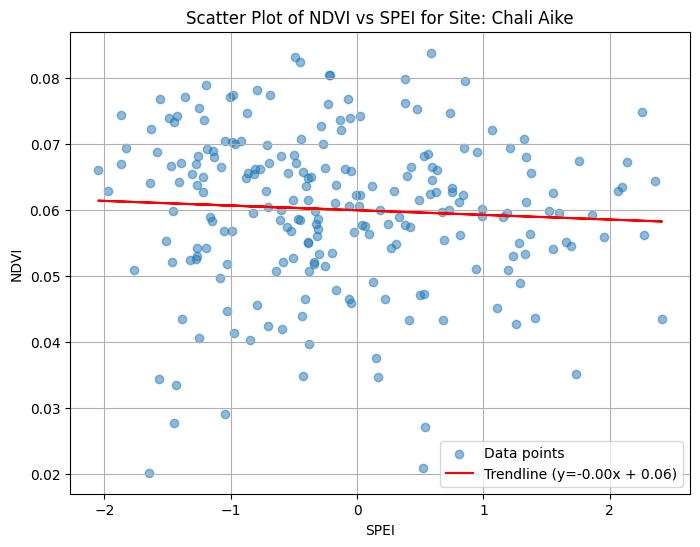

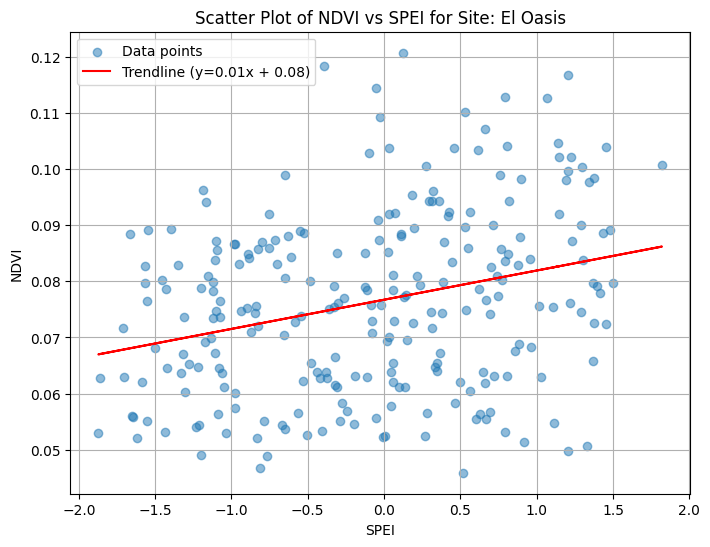

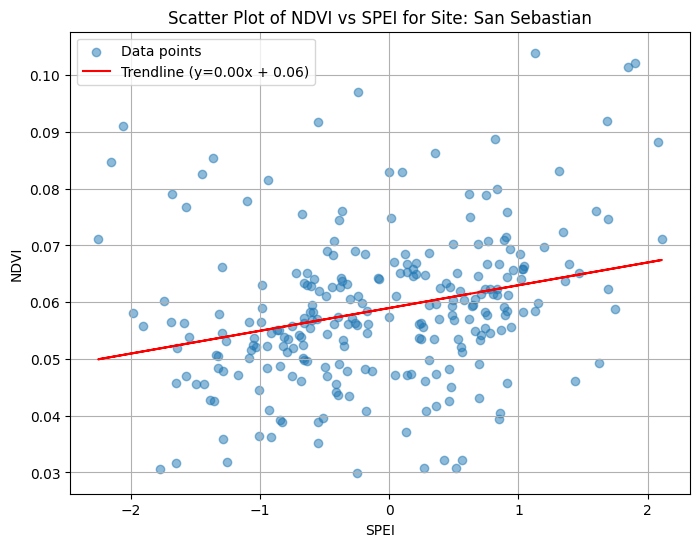

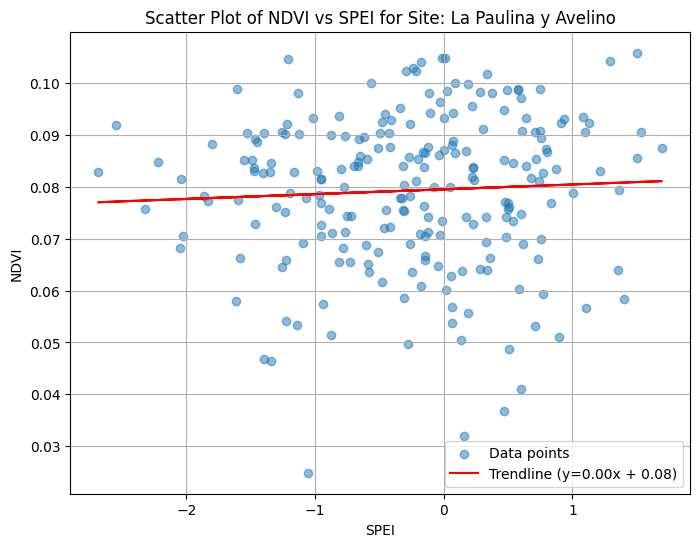

In [ ]:
# List of site names to plot
site_names = ['Chali Aike', 'El Oasis', 'San Sebastian', 'La Paulina y Avelino']


# Create scatter plots with trendlines for each site name
for site in site_names:
    # Filter the DataFrame for the specific Site_Name
    site_data = NDVI_SPEI_merged[NDVI_SPEI_merged['Site_Name'] == site]

    # Drop rows with NA values in 'SPEI' or 'NDVI'
    site_data = site_data.dropna(subset=['SPEI', 'NDVI'])

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(site_data['SPEI'], site_data['NDVI'], alpha=0.5, label='Data points')

    # Calculate the line of best fit (linear regression)
    if len(site_data) > 1:  # Ensure there are enough points to calculate a trendline
        slope, intercept = np.polyfit(site_data['SPEI'], site_data['NDVI'], 1)
        trendline = slope * site_data['SPEI'] + intercept

        # Plot the trendline
        plt.plot(site_data['SPEI'], trendline, color='red', label=f'Trendline (y={slope:.2f}x + {intercept:.2f})')

    # Add title and labels
    plt.title(f'Scatter Plot of NDVI vs SPEI for Site: {site}')
    plt.xlabel('SPEI')
    plt.ylabel('NDVI')

    # Add legend
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()

### c) Plotting the average NDVIs vs. SPEI over time, as in the paper.

In [ ]:
Two_NDVI_SPEI_merged

,year_month,Site_Name,NDVI,SPEI,NDVI_modis
0,2000_01,1 Rio Guenguel,0.04255,-1.202183,NaN
1,2000_02,1 Rio Guenguel,0.04015,-0.862369,0.14080
2,2000_03,1 Rio Guenguel,0.03890,-0.742418,0.13175
3,2000_04,1 Rio Guenguel,0.04640,-0.189822,0.14920
4,2000_05,1 Rio Guenguel,NaN,-0.093864,0.13650
...,...,...,...,...,...
26573,2022_08,Yague,0.07060,1.864572,0.23035
26574,2022_09,Yague,0.06310,2.043146,0.24560
26575,2022_10,Yague,0.08110,1.792258,0.25960
26576,2022_11,Yague,0.08780,1.636023,0.26235


### d.) Getting the average of each Z-score.

In [ ]:
# Define the columns for which we want to calculate the mean
mean_columns = ['NDVI', 'SPEI', 'NDVI_modis', 'zscore_NDVI', 'zscore_SPEI', 'zscore_NDVI_modis']

# Group by 'year_month' and calculate the mean for the selected columns
Mean_Two_NDVI_SPEI_merged = Two_NDVI_SPEI_cluster_merged.groupby(['year_month'])[mean_columns].mean().reset_index()

Mean_Two_NDVI_SPEI_merged_cluster  = Two_NDVI_SPEI_cluster_merged.groupby(['year_month', 'cluster'])[mean_columns].mean().reset_index()
#Two_NDVI_SPEI_cluster_merged
# Display the resulting DataFrame
print(Mean_Two_NDVI_SPEI_merged)

    year_month      NDVI      SPEI  NDVI_modis  zscore_NDVI  zscore_SPEI  \
0      2000_01  0.059840 -0.092331         NaN    -0.319954     0.023648   
1      2000_02  0.055493  0.156698    0.166142    -0.529489     0.294568   
2      2000_03  0.056140 -0.077749    0.165571    -0.498299     0.039512   
3      2000_04  0.053255 -0.015340    0.174598    -0.637346     0.107407   
4      2000_05  0.053921 -0.074739    0.189787    -0.605226     0.042786   
..         ...       ...       ...         ...          ...          ...   
269    2022_08  0.062326  0.192933    0.183888    -0.200122     0.333989   
270    2022_09  0.068128  0.635901    0.204176     0.079575     0.815896   
271    2022_10  0.078940  0.198400    0.213496     0.600715     0.339936   
272    2022_11  0.087535  0.301011    0.217206     1.014974     0.451567   
273    2022_12  0.084114  0.428274    0.206130     0.850095     0.590018   

     zscore_NDVI_modis  
0                  NaN  
1            -0.350943  
2           

## 4.3) Z-Scores

### a.) Plot Z-scores of Landsat NDVI & SPEI, respectively.

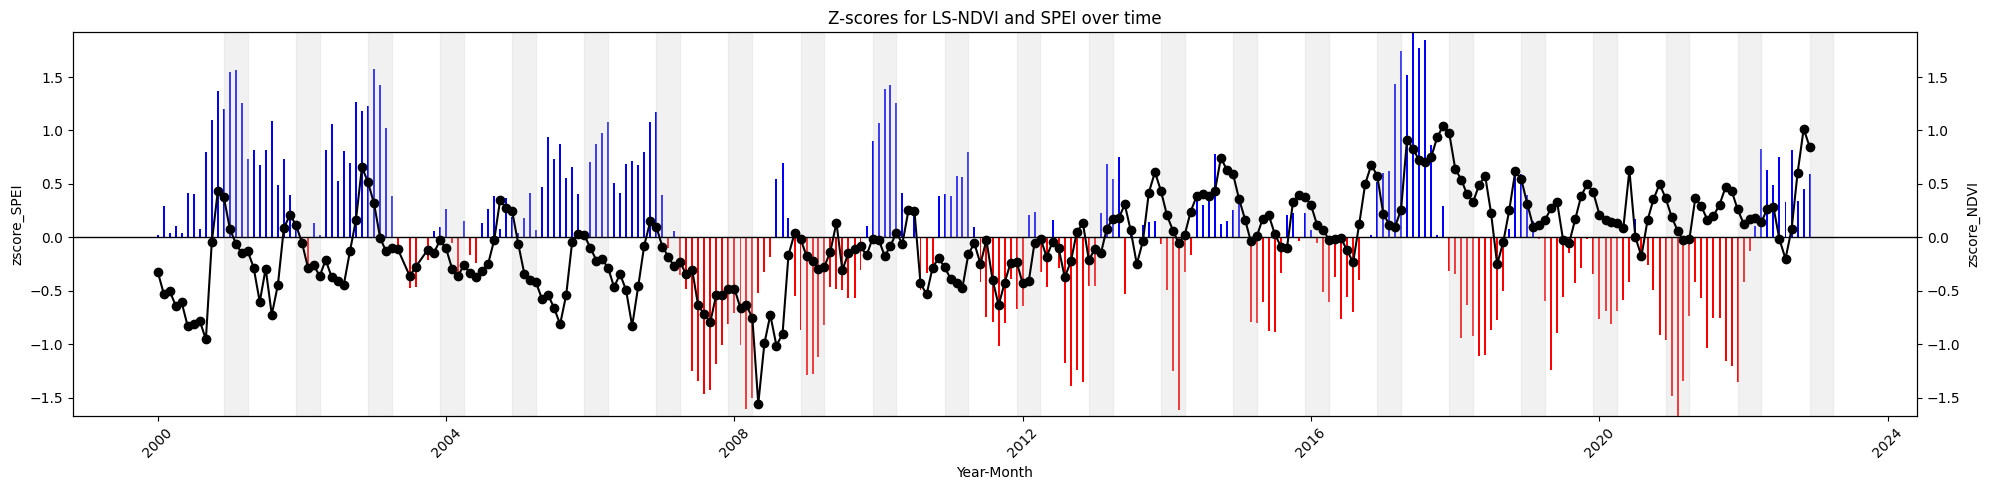

In [ ]:
# Convert 'year_month' column to datetime format
Mean_Two_NDVI_SPEI_merged['year_month_datetime'] = pd.to_datetime(Mean_Two_NDVI_SPEI_merged['year_month'], format='%Y_%m')

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(20, 5))

# Plotting the zscore_SPEI as bars: Red for negative and Blue for positive
colors = Mean_Two_NDVI_SPEI_merged['zscore_SPEI'].apply(lambda x: 'blue' if x >= 0 else 'red')
bar_width = 10

# Using 'year_month_datetime' for the x-axis
ax1.bar(Mean_Two_NDVI_SPEI_merged['year_month_datetime'],
        Mean_Two_NDVI_SPEI_merged['zscore_SPEI'],
        color=colors, width=bar_width)

# Plot a horizontal line at y=0
ax1.axhline(y=0, color='black', linewidth=1)

# Set labels and title for the first axis (zscore_SPEI)
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('zscore_SPEI')
ax1.set_title('Z-scores for LS-NDVI and SPEI over time')
ax1.tick_params(axis='x', rotation=45)

# Create a second y-axis for the zscore_NDVI line plot
ax2 = ax1.twinx()

# Plot the zscore_NDVI values using the 'year_month_datetime' column for the x-axis
ax2.plot(Mean_Two_NDVI_SPEI_merged['year_month_datetime'],
         Mean_Two_NDVI_SPEI_merged['zscore_NDVI'],
         marker='o', linestyle='-', color='black', label='zscore_NDVI')

# Set labels for the second axis (zscore_NDVI)
ax2.set_ylabel('zscore_NDVI')

# Calculate the overall range for both y-axes to be symmetric
ymin = min(Mean_Two_NDVI_SPEI_merged['zscore_SPEI'].min(), Mean_Two_NDVI_SPEI_merged['zscore_NDVI'].min())
ymax = max(Mean_Two_NDVI_SPEI_merged['zscore_SPEI'].max(), Mean_Two_NDVI_SPEI_merged['zscore_NDVI'].max())

# Ensure that the y-axes are centered around 0 and have the same range
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

# Add light grey transparent rectangles from April to November for each year
for year in Mean_Two_NDVI_SPEI_merged['year_month_datetime'].dt.year.unique():
    start_date = pd.Timestamp(f'{year}-12-01')  # 1st December
    end_date = pd.Timestamp(f'{year+1}-03-31')    # 31st March
    ax1.axvspan(start_date, end_date, color='lightgrey', alpha=0.3)

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the combined plot
plt.show()


### b) Plot the same as a.) - but with the actual values

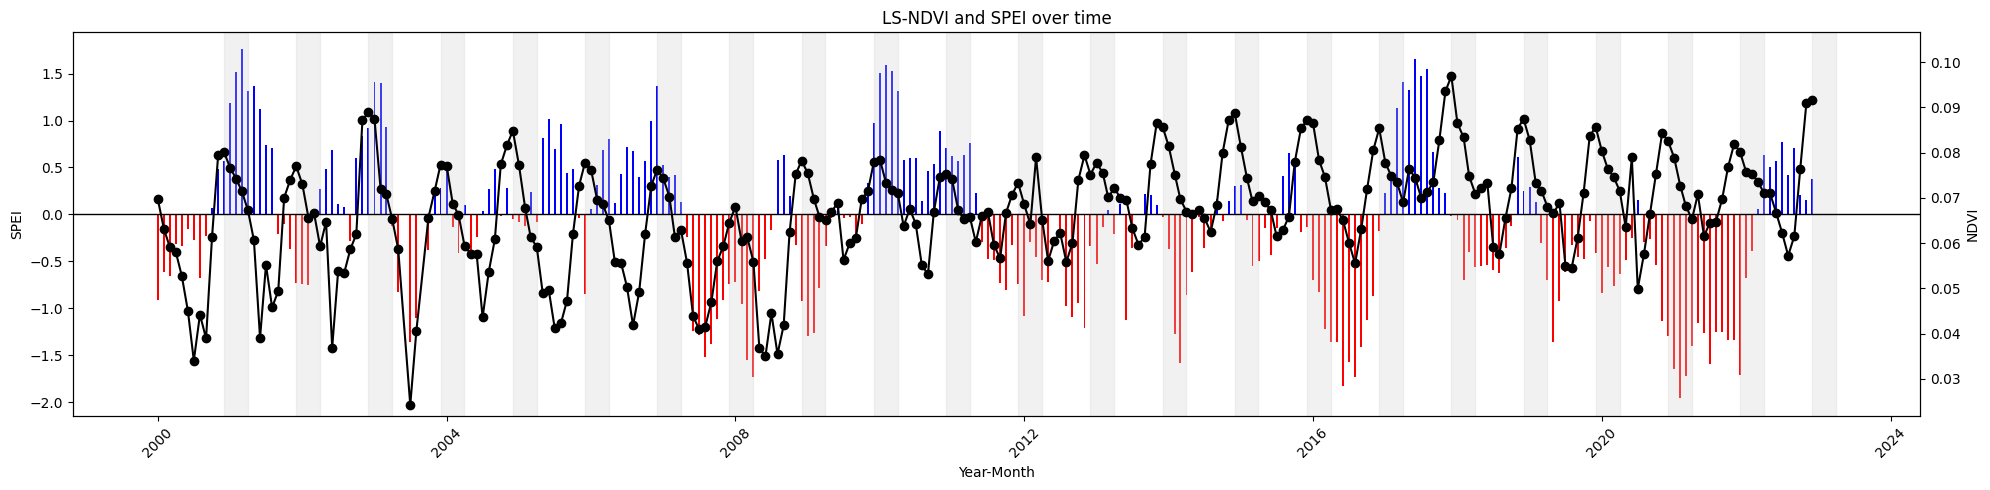

In [ ]:
Plotting_dataframe_NDVIvsSPEI = Mean_Two_NDVI_SPEI_merged_cluster.copy()

Plotting_dataframe_NDVIvsSPEI = Plotting_dataframe_NDVIvsSPEI[Plotting_dataframe_NDVIvsSPEI['cluster'] == 1]


# Convert 'year_month' column to datetime format
Plotting_dataframe_NDVIvsSPEI['year_month_datetime'] = pd.to_datetime(Plotting_dataframe_NDVIvsSPEI['year_month'], format='%Y_%m')

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(20, 5))

# Plotting the SPEI as bars: Red for negative and Blue for positive
colors = Plotting_dataframe_NDVIvsSPEI['SPEI'].apply(lambda x: 'blue' if x >= 0 else 'red')
bar_width = 10

# Using 'year_month_datetime' for the x-axis
ax1.bar(Plotting_dataframe_NDVIvsSPEI['year_month_datetime'],
        Plotting_dataframe_NDVIvsSPEI['SPEI'],
        color=colors, width=bar_width)

# Plot a horizontal line at y=0
ax1.axhline(y=0, color='black', linewidth=1)

# Set labels and title for the first axis (SPEI)
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('SPEI')
ax1.set_title('LS-NDVI and SPEI over time')
ax1.tick_params(axis='x', rotation=45)

# Create a second y-axis for the NDVI line plot
ax2 = ax1.twinx()

# Plot the NDVI values using the 'year_month_datetime' column for the x-axis
ax2.plot(Plotting_dataframe_NDVIvsSPEI['year_month_datetime'],
         Plotting_dataframe_NDVIvsSPEI['NDVI'],
         marker='o', linestyle='-', color='black', label='NDVI')

# Set labels for the second axis (NDVI)
ax2.set_ylabel('NDVI')

# Calculate the overall range for both y-axes to be symmetric
ymin_SPEI = Plotting_dataframe_NDVIvsSPEI['SPEI'].min()*1.1
ymax_SPEI = Plotting_dataframe_NDVIvsSPEI['SPEI'].max()*1.1

ymin_NDVI = Plotting_dataframe_NDVIvsSPEI['NDVI'].min()*0.9
ymax_NDVI = Plotting_dataframe_NDVIvsSPEI['NDVI'].max()*1.1


# Ensure that the y-axes are centered around 0 and have the same range
ax1.set_ylim(ymin_SPEI, ymax_SPEI)
ax2.set_ylim(ymin_NDVI, ymax_NDVI)

# Add light grey transparent rectangles from April to November for each year
for year in Plotting_dataframe_NDVIvsSPEI['year_month_datetime'].dt.year.unique():
    start_date = pd.Timestamp(f'{year}-12-01')  # 1st December
    end_date = pd.Timestamp(f'{year+1}-03-31')    # 31st March
    ax1.axvspan(start_date, end_date, color='lightgrey', alpha=0.3)

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the combined plot
plt.show()


### c.) Plot the same as a.) - but with MODIS-NDVI.

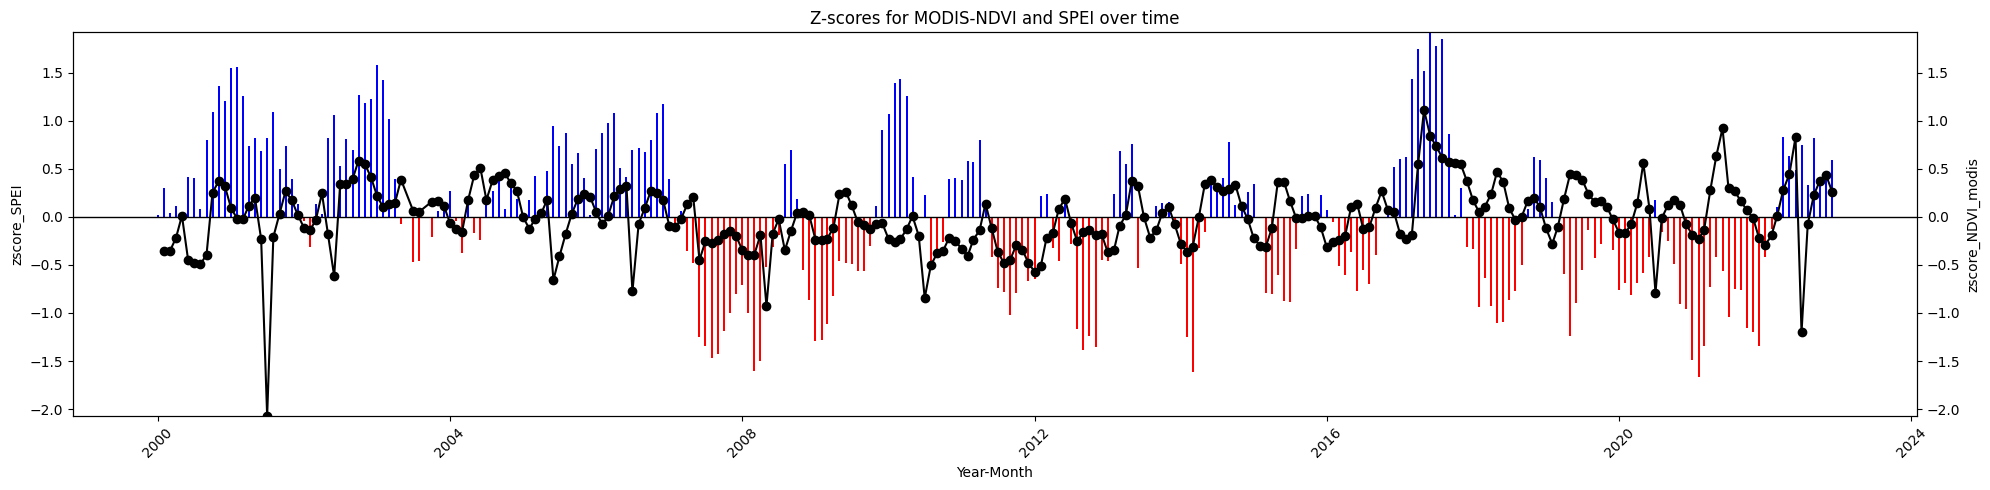

In [ ]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(20, 5))

# Plotting the zscore_SPEI as bars: Red for negative and Blue for positive
colors = Mean_Two_NDVI_SPEI_merged['zscore_SPEI'].apply(lambda x: 'blue' if x >= 0 else 'red')
bar_width = 10

# Using 'year_month_datetime' for the x-axis
ax1.bar(Mean_Two_NDVI_SPEI_merged['year_month_datetime'], Mean_Two_NDVI_SPEI_merged['zscore_SPEI'], color=colors, width=bar_width)

# Plot a horizontal line at y=0
ax1.axhline(y=0, color='black', linewidth=1)

# Set labels and title for the first axis (zscore_SPEI)
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('zscore_SPEI')
ax1.set_title('Z-scores for MODIS-NDVI and SPEI over time')
ax1.tick_params(axis='x', rotation=45)

# Create a second y-axis for the zscore_NDVI_modis line plot
ax2 = ax1.twinx()

# Plot the zscore_NDVI_modis values using the 'year_month_datetime' column for the x-axis
ax2.plot(Mean_Two_NDVI_SPEI_merged['year_month_datetime'], Mean_Two_NDVI_SPEI_merged['zscore_NDVI_modis'], marker='o', linestyle='-', color='black', label='zscore_NDVI_modis')

# Set labels for the second axis (zscore_NDVI_modis)
ax2.set_ylabel('zscore_NDVI_modis')

# Calculate the overall range for both y-axes to be symmetric
ymin = min(Mean_Two_NDVI_SPEI_merged['zscore_SPEI'].min(), Mean_Two_NDVI_SPEI_merged['zscore_NDVI_modis'].min())
ymax = max(Mean_Two_NDVI_SPEI_merged['zscore_SPEI'].max(), Mean_Two_NDVI_SPEI_merged['zscore_NDVI_modis'].max())

# Ensure that the y-axes are centered around 0 and have the same range
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the combined plot
plt.show()



### c.) Plot the same as a.) - but for both MODIS and LS.

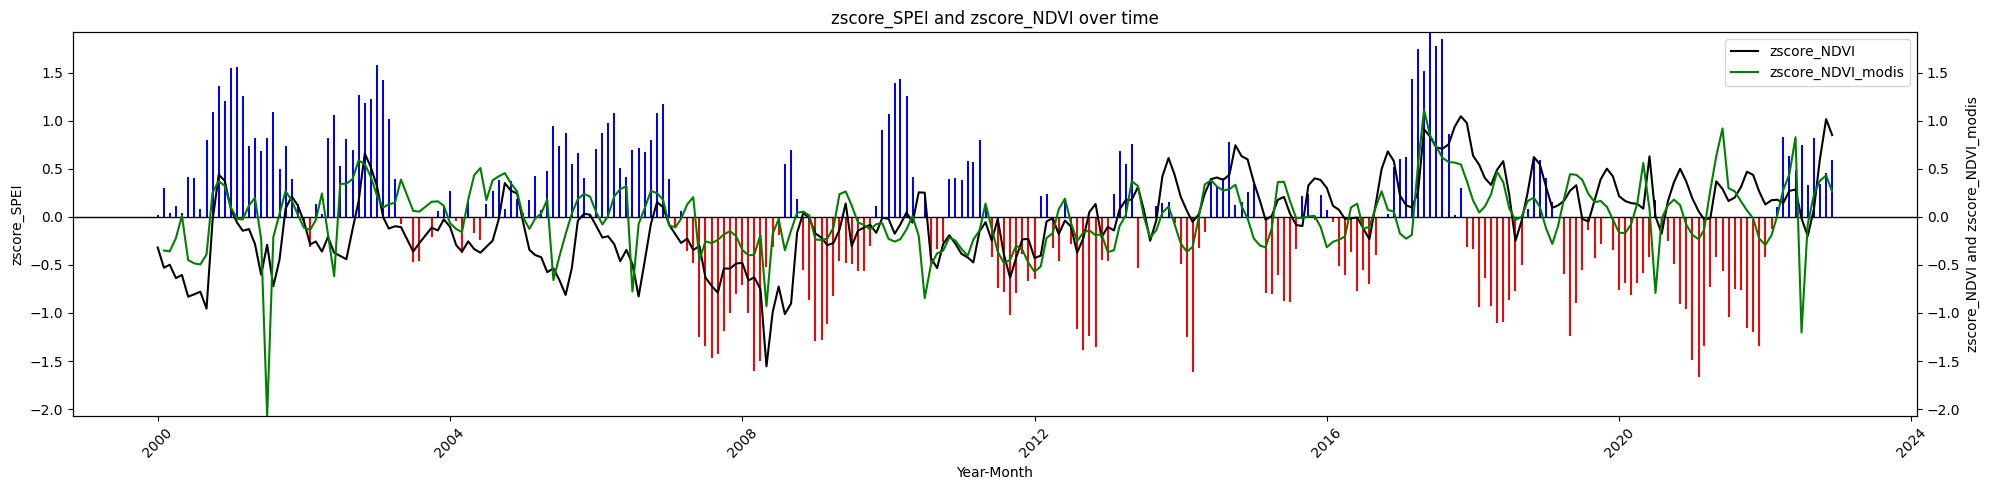

In [ ]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(20, 5))

# Plotting the zscore_SPEI as bars: Red for negative and Blue for positive
colors = Mean_Two_NDVI_SPEI_merged['zscore_SPEI'].apply(lambda x: 'blue' if x >= 0 else 'red')
bar_width = 10

# Using 'year_month_datetime' for the x-axis instead of the index
ax1.bar(Mean_Two_NDVI_SPEI_merged['year_month_datetime'], Mean_Two_NDVI_SPEI_merged['zscore_SPEI'], color=colors, width=bar_width)

# Plot a horizontal line at y=0
ax1.axhline(y=0, color='black', linewidth=1)

# Set labels and title for the first axis (zscore_SPEI)
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('zscore_SPEI')
ax1.set_title('zscore_SPEI and zscore_NDVI over time')
ax1.tick_params(axis='x', rotation=45)

# Create a second y-axis for the zscore_NDVI and zscore_NDVI_modis lines
ax2 = ax1.twinx()



# Plot the zscore_NDVI values using the 'year_month_datetime' column for the x-axis (without markers)
ax2.plot(Mean_Two_NDVI_SPEI_merged['year_month_datetime'], Mean_Two_NDVI_SPEI_merged['zscore_NDVI'], linestyle='-', color='black', label='zscore_NDVI')

# Plot the zscore_NDVI_modis values as a line as well (without markers)
ax2.plot(Mean_Two_NDVI_SPEI_merged['year_month_datetime'], Mean_Two_NDVI_SPEI_merged['zscore_NDVI_modis'], linestyle='-', color='green', label='zscore_NDVI_modis')

# Set labels for the second axis (zscore_NDVI and zscore_NDVI_modis)
ax2.set_ylabel('zscore_NDVI and zscore_NDVI_modis')

# Add legends for the line plots
ax2.legend(loc='upper right')

# Calculate the overall range for both y-axes to be symmetric
ymin = min(Mean_Two_NDVI_SPEI_merged['zscore_SPEI'].min(), Mean_Two_NDVI_SPEI_merged['zscore_NDVI'].min(), Mean_Two_NDVI_SPEI_merged['zscore_NDVI_modis'].min())
ymax = max(Mean_Two_NDVI_SPEI_merged['zscore_SPEI'].max(), Mean_Two_NDVI_SPEI_merged['zscore_NDVI'].max(), Mean_Two_NDVI_SPEI_merged['zscore_NDVI_modis'].max())

# Ensure that the y-axes are centered around 0 and have the same range
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the combined plot
plt.show()

## 4.4) Dry season in Patagonia.

### a.) Plot LS NDVI and SPEI for Patagonian dry season (December to March).

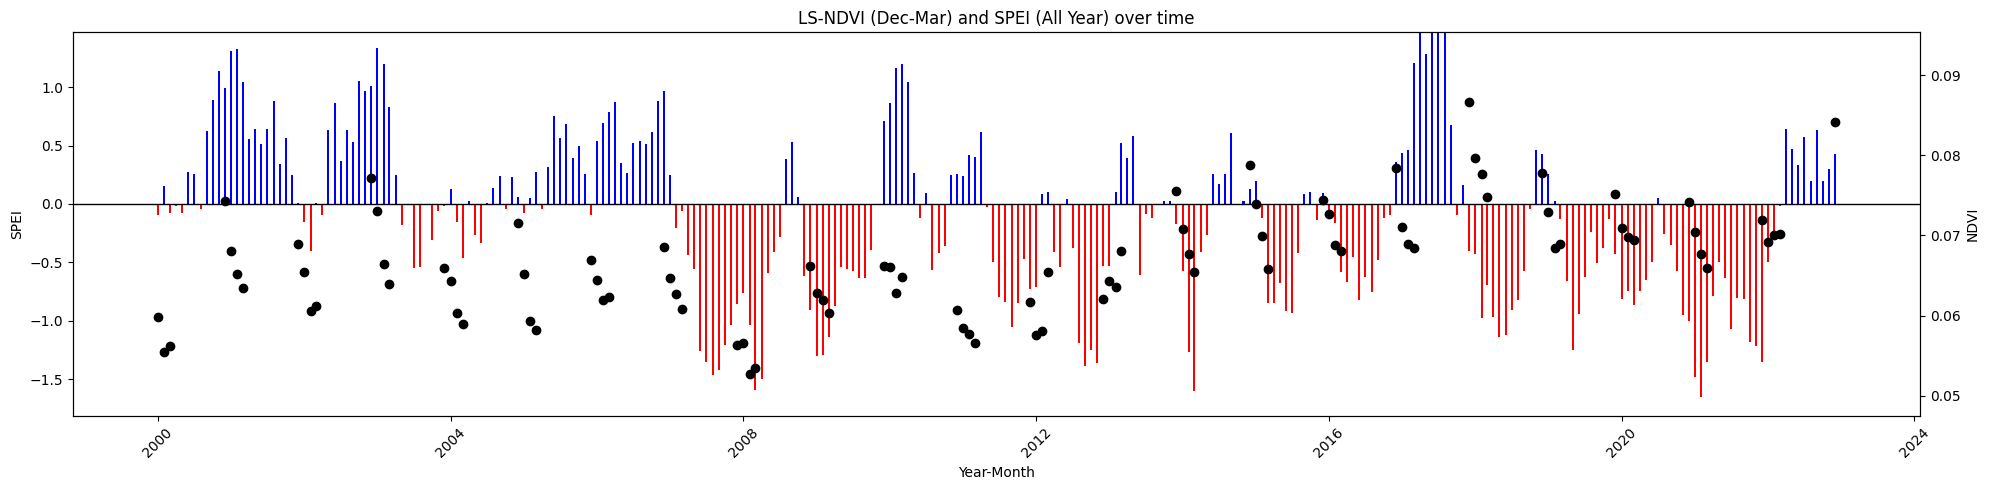

In [ ]:
# Convert 'year_month' column to datetime format
Mean_Two_NDVI_SPEI_merged['year_month_datetime'] = pd.to_datetime(Mean_Two_NDVI_SPEI_merged['year_month'], format='%Y_%m')

# Extract the month from 'year_month_datetime' and filter NDVI data for Patagonian Dry Season (December to March)
Mean_Two_NDVI_SPEI_merged['month'] = Mean_Two_NDVI_SPEI_merged['year_month_datetime'].dt.month
ndvi_dry_season = Mean_Two_NDVI_SPEI_merged[(Mean_Two_NDVI_SPEI_merged['month'] >= 12) | (Mean_Two_NDVI_SPEI_merged['month'] <= 3)]

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(20, 5))

# Plotting the SPEI as bars: Red for negative and Blue for positive (for the entire year)
colors = Mean_Two_NDVI_SPEI_merged['SPEI'].apply(lambda x: 'blue' if x >= 0 else 'red')
bar_width = 10

# Using 'year_month_datetime' for the x-axis for SPEI (all months)
ax1.bar(Mean_Two_NDVI_SPEI_merged['year_month_datetime'],
        Mean_Two_NDVI_SPEI_merged['SPEI'],
        color=colors, width=bar_width)

# Plot a horizontal line at y=0
ax1.axhline(y=0, color='black', linewidth=1)

# Set labels and title for the first axis (SPEI)
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('SPEI')
ax1.set_title('LS-NDVI (Dec-Mar) and SPEI (All Year) over time')
ax1.tick_params(axis='x', rotation=45)

# Create a second y-axis for the zscore_NDVI scatter plot (points only for Dec-Mar)
ax2 = ax1.twinx()

# Plot the zscore_NDVI values as points using the 'year_month_datetime' column for the x-axis (filtered for Dec-Mar)
ax2.scatter(ndvi_dry_season['year_month_datetime'],
            ndvi_dry_season['NDVI'],
            color='black', label='NDVI')

# Set labels for the second axis (NDVI)
ax2.set_ylabel('NDVI')


# Calculate the overall range for both y-axes to be symmetric
ymin_SPEI = ndvi_dry_season['SPEI'].min()*1.1
ymax_SPEI = ndvi_dry_season['SPEI'].max()*1.1

ymin_NDVI = ndvi_dry_season['NDVI'].min()*0.9
ymax_NDVI = ndvi_dry_season['NDVI'].max()*1.1

# Ensure that the y-axes are centered around 0 and have the same range
ax1.set_ylim(ymin_SPEI, ymax_SPEI)
ax2.set_ylim(ymin_NDVI, ymax_NDVI)

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the combined plot
plt.show()


## 4.5) Correlations for each year

### a) For Landsat vs SPEI

<ipython-input-30-6ef07cbb191b>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_by_year = Mean_Two_NDVI_SPEI_merged.groupby('year').apply(lambda x: x['zscore_NDVI'].corr(x['zscore_SPEI']))
<ipython-input-30-6ef07cbb191b>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_by_year = Mean_Two_NDVI_SPEI_merged.groupby('year').apply(lambda x: x['zscore_NDVI'].corr(x['zscore_SPEI']))


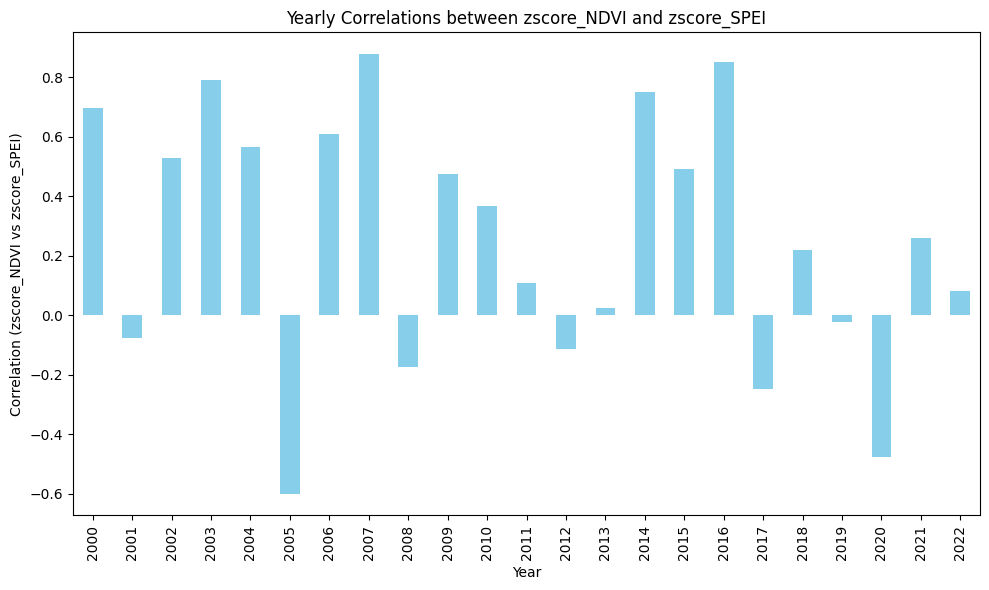

In [ ]:
# Step 1: Extract the year from 'year_month_datetime'
Mean_Two_NDVI_SPEI_merged['year'] = Mean_Two_NDVI_SPEI_merged['year_month_datetime'].dt.year

# Step 2: Group by the 'year' column
# Step 3: Calculate the correlation between 'zscore_NDVI' and 'zscore_SPEI' for each year
correlations_by_year = Mean_Two_NDVI_SPEI_merged.groupby('year').apply(lambda x: x['zscore_NDVI'].corr(x['zscore_SPEI']))

# Display the correlations
#print(correlations_by_year)

# Step 1: Extract the year from 'year_month_datetime'
Mean_Two_NDVI_SPEI_merged['year'] = Mean_Two_NDVI_SPEI_merged['year_month_datetime'].dt.year

# Step 2: Group by the 'year' column and calculate the correlation between 'zscore_NDVI' and 'zscore_SPEI' for each year
correlations_by_year = Mean_Two_NDVI_SPEI_merged.groupby('year').apply(lambda x: x['zscore_NDVI'].corr(x['zscore_SPEI']))

# Step 3: Plot the correlations as a bar plot
correlations_by_year.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Step 4: Set the labels and title
plt.xlabel('Year')
plt.ylabel('Correlation (zscore_NDVI vs zscore_SPEI)')
plt.title('Yearly Correlations between zscore_NDVI and zscore_SPEI')

# Show the plot
plt.tight_layout()
plt.show()

### b) For MODIS vs SPEI

<ipython-input-31-9dc67312b2d0>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_by_year_MODIS = Mean_Two_NDVI_SPEI_merged.groupby('year').apply(lambda x: x['zscore_NDVI_modis'].corr(x['zscore_SPEI']))
<ipython-input-31-9dc67312b2d0>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_by_year_MODIS = Mean_Two_NDVI_SPEI_merged.groupby('year').apply(lambda x: x['zscore_NDVI_modis'].cor

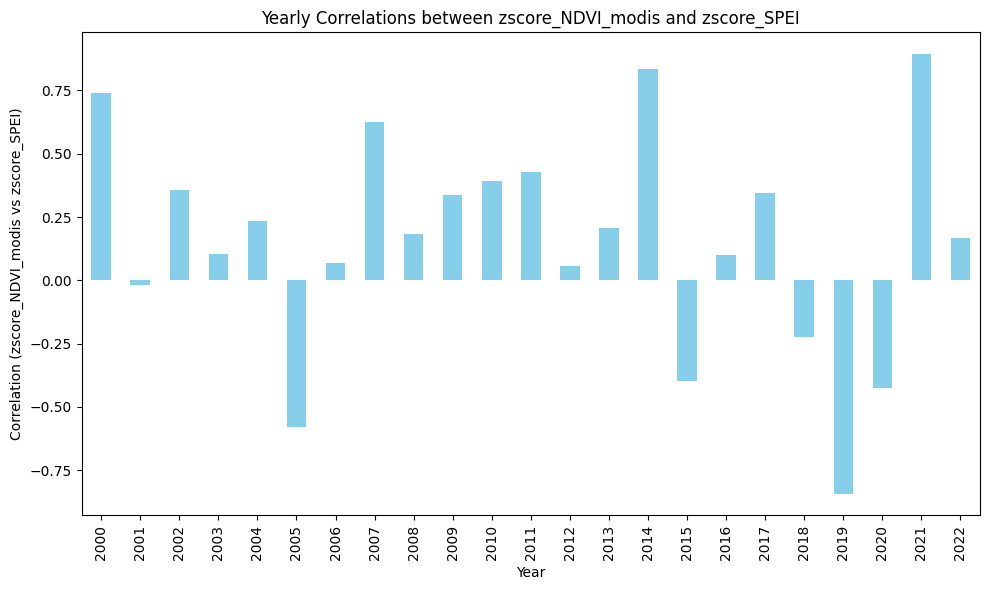

In [ ]:
# Step 1: Extract the year from 'year_month_datetime'
Mean_Two_NDVI_SPEI_merged['year'] = Mean_Two_NDVI_SPEI_merged['year_month_datetime'].dt.year

# Step 2: Group by the 'year' column
# Step 3: Calculate the correlation between 'zscore_NDVI_modis' and 'zscore_SPEI' for each year
correlations_by_year_MODIS = Mean_Two_NDVI_SPEI_merged.groupby('year').apply(lambda x: x['zscore_NDVI_modis'].corr(x['zscore_SPEI']))

# Display the correlations
#print(correlations_by_year_MODIS)

# Step 1: Extract the year from 'year_month_datetime'
Mean_Two_NDVI_SPEI_merged['year'] = Mean_Two_NDVI_SPEI_merged['year_month_datetime'].dt.year

# Step 2: Group by the 'year' column and calculate the correlation between 'zscore_NDVI_modis' and 'zscore_SPEI' for each year
correlations_by_year_MODIS = Mean_Two_NDVI_SPEI_merged.groupby('year').apply(lambda x: x['zscore_NDVI_modis'].corr(x['zscore_SPEI']))

# Step 3: Plot the correlations as a bar plot
correlations_by_year_MODIS.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Step 4: Set the labels and title
plt.xlabel('Year')
plt.ylabel('Correlation (zscore_NDVI_modis vs zscore_SPEI)')
plt.title('Yearly Correlations between zscore_NDVI_modis and zscore_SPEI')

# Show the plot
plt.tight_layout()
plt.show()

## 4.6) Correlations per cluster

<ipython-input-32-8e31e3c66dde>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_by_cluster = Two_NDVI_SPEI_cluster_merged.groupby('cluster').apply(lambda x: x['zscore_NDVI'].corr(x['zscore_SPEI']))
<ipython-input-32-8e31e3c66dde>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_by_cluster = Two_NDVI_SPEI_cluster_merged.groupby('cluster').apply(lambda x: x['zscore_NDVI'].corr(x['z

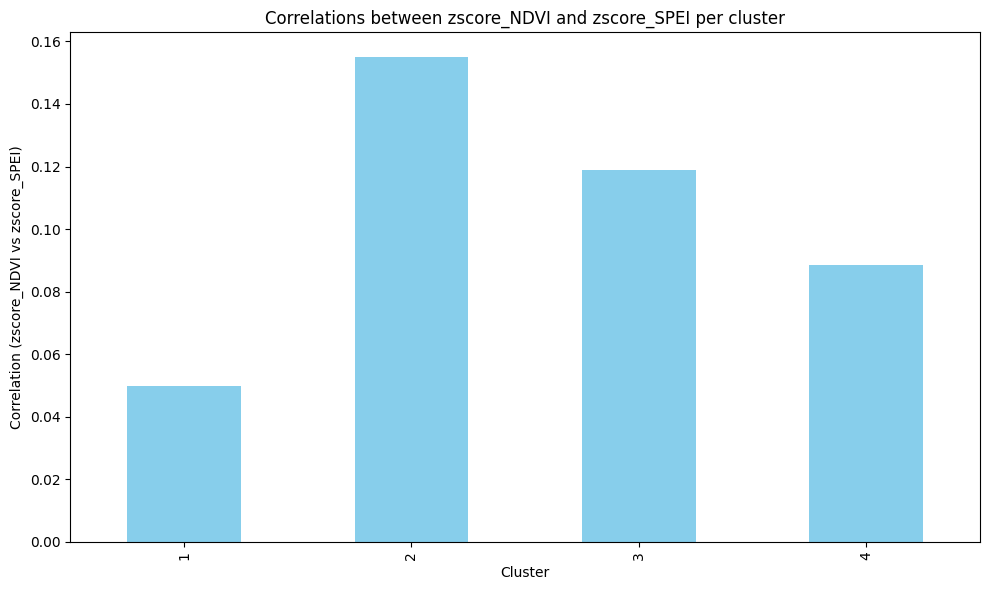

In [ ]:
# Step 1: Extract the year from 'year_month_datetime'
# Two_NDVI_SPEI_cluster_merged['year'] = Two_NDVI_SPEI_cluster_merged['year_month_datetime'].dt.year

# Step 2: Group by the 'cluster' column
# Step 3: Calculate the correlation between 'zscore_NDVI' and 'zscore_SPEI' for each year
correlations_by_cluster = Two_NDVI_SPEI_cluster_merged.groupby('cluster').apply(lambda x: x['zscore_NDVI'].corr(x['zscore_SPEI']))

# Display the correlations
# print(correlations_by_cluster)

# Step 1: Extract the year from 'year_month_datetime'
# Two_NDVI_SPEI_cluster_merged['year'] = Two_NDVI_SPEI_cluster_merged['year_month_datetime'].dt.year

# Step 2: Group by the 'cluster' column and calculate the correlation between 'zscore_NDVI' and 'zscore_SPEI' for each year
correlations_by_cluster = Two_NDVI_SPEI_cluster_merged.groupby('cluster').apply(lambda x: x['zscore_NDVI'].corr(x['zscore_SPEI']))

# Step 3: Plot the correlations as a bar plot
correlations_by_cluster.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Step 4: Set the labels and title
plt.xlabel('Cluster')
plt.ylabel('Correlation (zscore_NDVI vs zscore_SPEI)')
plt.title('Correlations between zscore_NDVI and zscore_SPEI per cluster')

# Show the plot
plt.tight_layout()
plt.show()

# 5) Split according to biozones


## 5.1) Import MARAS data

In [ ]:
# Load the CSV file into a DataFrame
maras_chubut = pd.read_csv('Data/MARAS_Chubut_utf8.csv', sep=';')

# Test
print(maras_chubut.head())

     Country Province Site_Name       ID  DB_code  Lectura        Date  \
0  Argentina   Chubut      CERM  #CH-001      301        1  18-06-2008   
1  Argentina   Chubut      CERM  #CH-001      301        2  21-01-2014   
2  Argentina   Chubut      CERM  #CH-001      301        3  14-12-2018   
3  Argentina   Chubut    La Ana  #CH-002      302        1  21-04-2009   
4  Argentina   Chubut    La Ana  #CH-002      302        2  24-01-2014   

     Latitude   Longitude  Altitude  ... Patch_Silt Patch_Sand InterP_Con  \
0  -45,440611  -70,300306       543  ...        NaN        NaN        NaN   
1  -45,440611  -70,300306       543  ...        NaN        NaN       0,33   
2  -45,440611  -70,300306       543  ...         12         86       0,31   
3   -45,42675  -70,267778       535  ...        NaN        NaN        NaN   
4   -45,42675  -70,267778       535  ...        NaN        NaN       0,24   

  InterP_pH  InterP_OC InterP_N  InterP_OM InterP_Clay  InterP_Silt  \
0        NaN       Na

## 5.2) Merge with the NDVI data

In [ ]:
# Merge Two_NDVI_SPEI_merged with cluster_df on 'Site_Name'
NDVI_SPEI_MARAS = pd.merge(Two_NDVI_SPEI_merged, maras_chubut, on='Site_Name', how='inner')

NDVI_SPEI_MARAS.columns

Index(['year_month', 'Site_Name', 'NDVI', 'SPEI', 'NDVI_modis', 'Country',
       'Province', 'ID', 'DB_code', 'Lectura', 'Date', 'Latitude', 'Longitude',
       'Altitude', 'StDens_EE', 'StDens_AU', 'AI', 'Departament ', 'Landform ',
       'Biozone', 'MAP', 'Temp_mean', 'SR', 'Sh_W', 'VegCov', 'Rock_Stone',
       'BS', 'Litter', 'Ephemerals', 'Dead_Stand', 'Cryptogams', 'BasalCov',
       'Len_InterP', 'Len_Patch', 'Width_Patch', 'Height_Patch', 'Nr_Patches',
       'Stability', 'Infiltration', 'Nutri_Recy', 'Patch_Con', 'Patch_pH ',
       'Patch_OC', 'Patch_N', 'Patch_OM', 'Patch_Clay', 'Patch_Silt',
       'Patch_Sand', 'InterP_Con', 'InterP_pH ', 'InterP_OC', 'InterP_N',
       'InterP_OM', 'InterP_Clay', 'InterP_Silt', 'InterP_Sand'],
      dtype='object')

In [ ]:
# Columns to calculate the means on
mean_columns = ["NDVI", "SPEI"]

# Group by 'year_month' and calculate the mean for the selected columns

NDVI_SPEI_MARAS_Biozone  = NDVI_SPEI_MARAS.groupby(['year_month', 'Biozone'])[mean_columns].median().reset_index()
#Two_NDVI_SPEI_cluster_merged
# Display the resulting DataFrame
print(NDVI_SPEI_MARAS_Biozone)

     year_month                    Biozone     NDVI      SPEI
0       2000_01    Austral Monte Shrubland  0.05880  1.110487
1       2000_01            Central Plateau  0.04870  0.397912
2       2000_01  Golfo San Jorge Shrubland  0.08430  0.631327
3       2000_01       Subandean grasslands  0.07335 -0.169275
4       2000_01   West Plateaus Shrublands  0.05920 -0.600158
...         ...                        ...      ...       ...
1365    2022_12    Austral Monte Shrubland  0.07900  0.908879
1366    2022_12            Central Plateau  0.07290  0.510863
1367    2022_12  Golfo San Jorge Shrubland  0.12670 -0.189152
1368    2022_12       Subandean grasslands  0.10770  0.717080
1369    2022_12   West Plateaus Shrublands  0.07965  0.442854

[1370 rows x 4 columns]


## 5.3) Plot all the Biozones using a loop

Austral Monte Shrubland


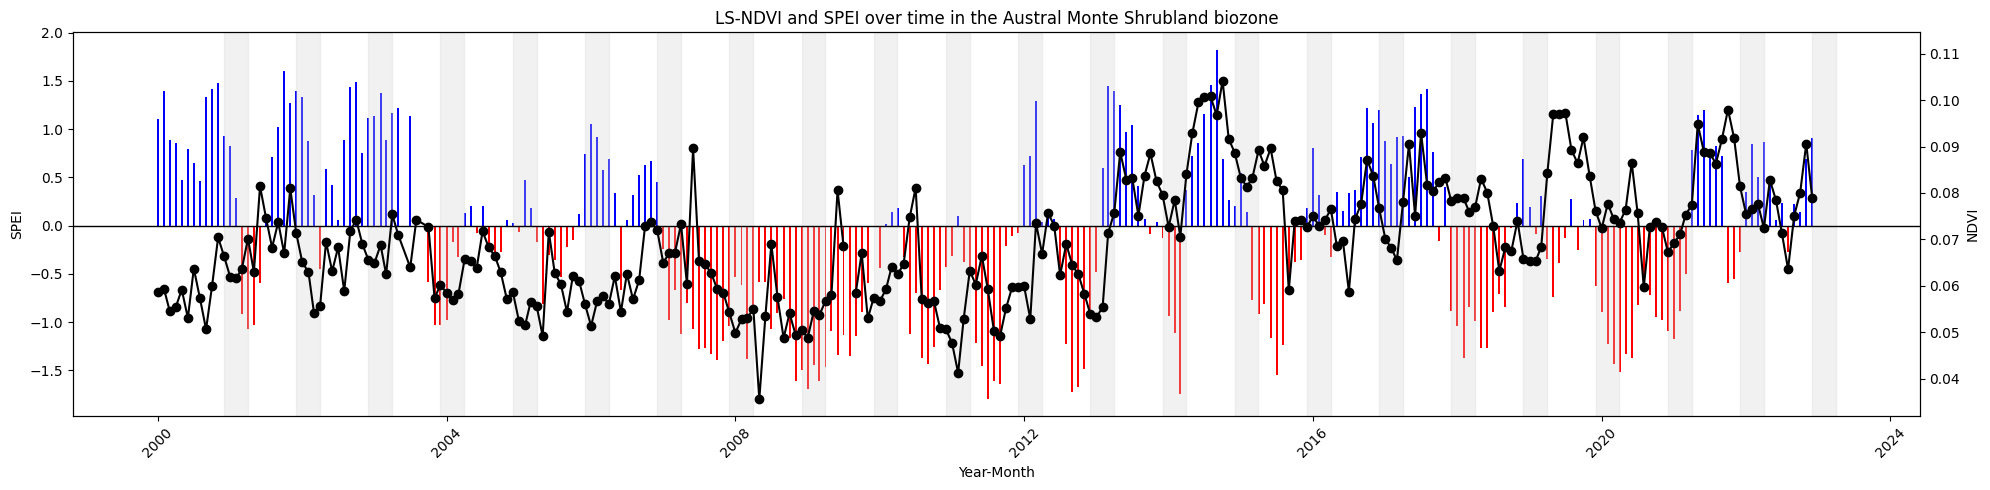

Central Plateau


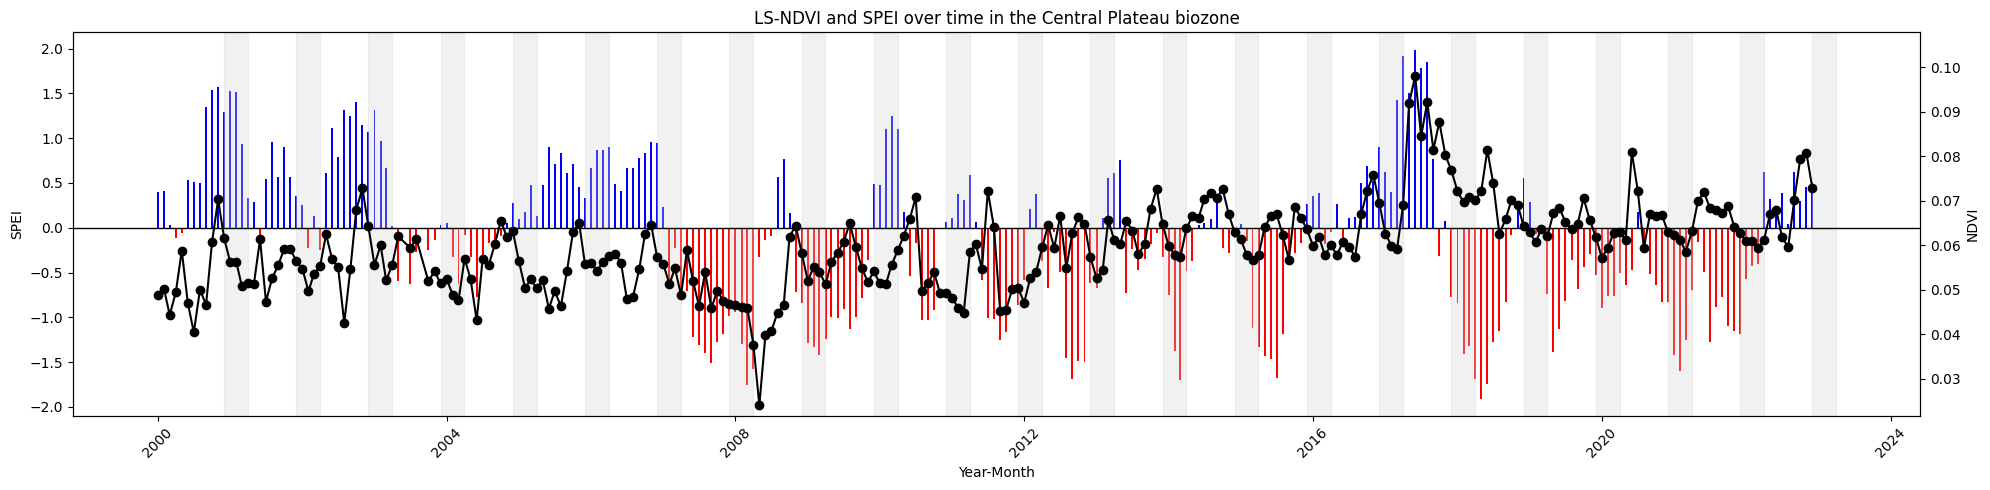

Golfo San Jorge Shrubland


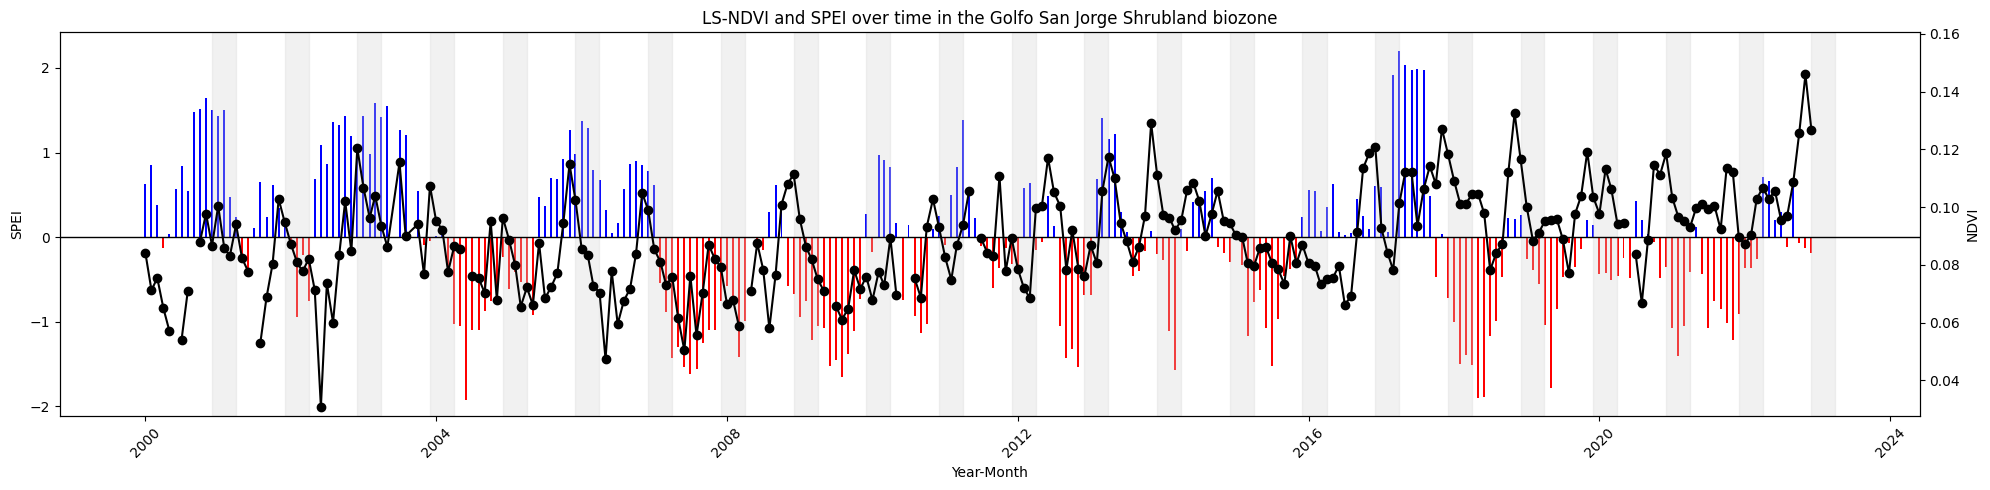

Subandean grasslands


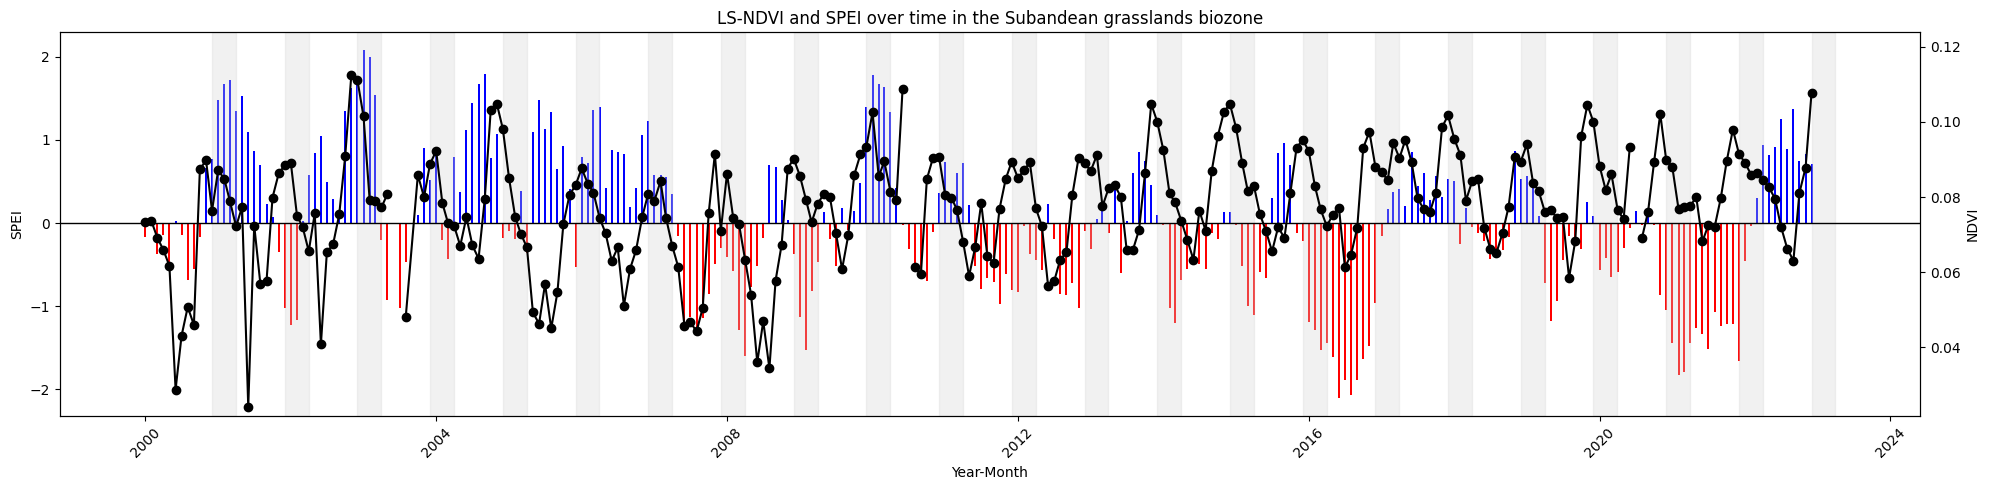

West Plateaus Shrublands


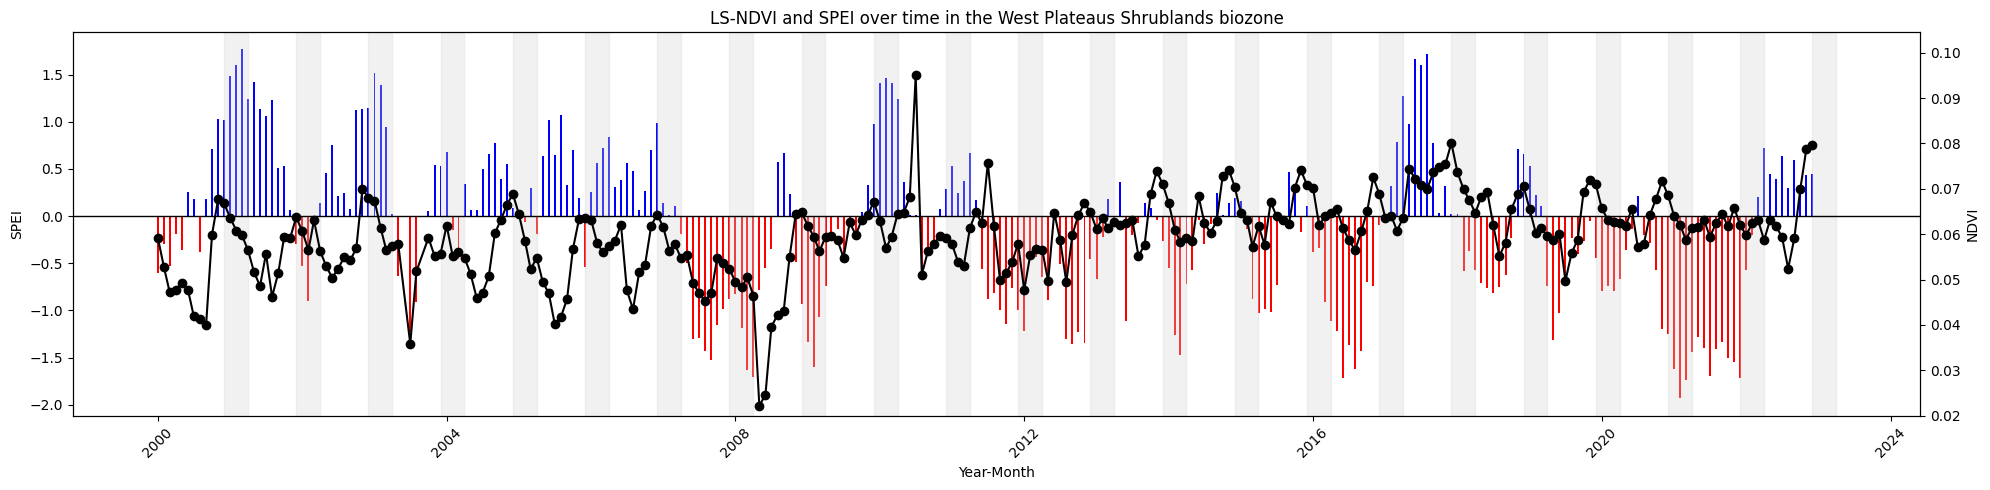

In [ ]:
for biozone in NDVI_SPEI_MARAS_Biozone["Biozone"].unique():
  print(biozone)

  Plotting_dataframe_NDVIvsSPEI = NDVI_SPEI_MARAS_Biozone.copy()

  Plotting_dataframe_NDVIvsSPEI = Plotting_dataframe_NDVIvsSPEI[Plotting_dataframe_NDVIvsSPEI['Biozone'] == biozone]


  # Convert 'year_month' column to datetime format
  Plotting_dataframe_NDVIvsSPEI['year_month_datetime'] = pd.to_datetime(Plotting_dataframe_NDVIvsSPEI['year_month'], format='%Y_%m')

  # Create a figure and a set of subplots
  fig, ax1 = plt.subplots(figsize=(20, 5))

  # Plotting the SPEI as bars: Red for negative and Blue for positive
  colors = Plotting_dataframe_NDVIvsSPEI['SPEI'].apply(lambda x: 'blue' if x >= 0 else 'red')
  bar_width = 10

  # Using 'year_month_datetime' for the x-axis
  ax1.bar(Plotting_dataframe_NDVIvsSPEI['year_month_datetime'],
          Plotting_dataframe_NDVIvsSPEI['SPEI'],
          color=colors, width=bar_width)

  # Plot a horizontal line at y=0
  ax1.axhline(y=0, color='black', linewidth=1)

  # Set labels and title for the first axis (SPEI)
  ax1.set_xlabel('Year-Month')
  ax1.set_ylabel('SPEI')
  ax1.set_title('LS-NDVI and SPEI over time in the ' + biozone + " biozone")
  ax1.tick_params(axis='x', rotation=45)

  # Create a second y-axis for the NDVI line plot
  ax2 = ax1.twinx()

  # Plot the NDVI values using the 'year_month_datetime' column for the x-axis
  ax2.plot(Plotting_dataframe_NDVIvsSPEI['year_month_datetime'],
          Plotting_dataframe_NDVIvsSPEI['NDVI'],
          marker='o', linestyle='-', color='black', label='NDVI')

  # Set labels for the second axis (NDVI)
  ax2.set_ylabel('NDVI')

  # Calculate the overall range for both y-axes to be symmetric
  ymin_SPEI = Plotting_dataframe_NDVIvsSPEI['SPEI'].min()*1.1
  ymax_SPEI = Plotting_dataframe_NDVIvsSPEI['SPEI'].max()*1.1

  ymin_NDVI = Plotting_dataframe_NDVIvsSPEI['NDVI'].min()*0.9
  ymax_NDVI = Plotting_dataframe_NDVIvsSPEI['NDVI'].max()*1.1


  # Ensure that the y-axes are centered around 0 and have the same range
  ax1.set_ylim(ymin_SPEI, ymax_SPEI)
  ax2.set_ylim(ymin_NDVI, ymax_NDVI)

  # Add light grey transparent rectangles from April to November for each year
  for year in Plotting_dataframe_NDVIvsSPEI['year_month_datetime'].dt.year.unique():
      start_date = pd.Timestamp(f'{year}-12-01')  # 1st December
      end_date = pd.Timestamp(f'{year+1}-03-31')    # 31st March
      ax1.axvspan(start_date, end_date, color='lightgrey', alpha=0.3)

  # Adjust layout to prevent overlap
  fig.tight_layout()

  # Show the combined plot
  plt.show()


## 5.4) Correlations per Biozone

Merge correlations with MARAS data

In [ ]:
NDVI_SPEI_MARAS_COR_BIOZONE = pd.merge(Two_NDVI_SPEI_cluster_merged, maras_chubut, on='Site_Name', how='inner')

NDVI_SPEI_MARAS_COR_BIOZONE

,year_month,Site_Name,NDVI,SPEI,NDVI_modis,cluster,zscore_NDVI,zscore_SPEI,zscore_NDVI_modis,Country,...,Patch_Silt,Patch_Sand,InterP_Con,InterP_pH,InterP_OC,InterP_N,InterP_OM,InterP_Clay,InterP_Silt,InterP_Sand
0,2000_01,1 San Felipe,0.0608,0.855075,NaN,2,-0.273669,1.054337,NaN,Argentina,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000_01,1 San Felipe,0.0608,0.855075,NaN,2,-0.273669,1.054337,NaN,Argentina,...,NaN,NaN,"0,37",8,"1,2","0,07","2,07",NaN,NaN,NaN
2,2000_01,1 San Felipe,0.0608,0.855075,NaN,2,-0.273669,1.054337,NaN,Argentina,...,21,76,"0,53","7,1","0,22","0,03","0,38",5,11,84
3,2000_02,1 San Felipe,0.0664,1.536438,0.16320,2,-0.003741,1.795597,-0.395985,Argentina,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000_02,1 San Felipe,0.0664,1.536438,0.16320,2,-0.003741,1.795597,-0.395985,Argentina,...,NaN,NaN,"0,37",8,"1,2","0,07","2,07",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53699,2022_11,Yague,0.0878,1.636023,0.26235,1,1.027769,1.903936,1.121871,Argentina,...,"17,6",82,NaN,NaN,2,NaN,"3,5","0,9","18,4","80,7"
53700,2022_11,Yague,0.0878,1.636023,0.26235,1,1.027769,1.903936,1.121871,Argentina,...,NaN,NaN,"0,06","6,07","1,53",NaN,"2,64",NaN,NaN,NaN
53701,2022_12,Yague,0.0826,1.491261,0.26130,1,0.777122,1.746449,1.105797,Argentina,...,NaN,NaN,NaN,NaN,"2,02",NaN,"3,49",NaN,NaN,NaN
53702,2022_12,Yague,0.0826,1.491261,0.26130,1,0.777122,1.746449,1.105797,Argentina,...,"17,6",82,NaN,NaN,2,NaN,"3,5","0,9","18,4","80,7"


<ipython-input-38-54d5f4fd6743>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_by_biozone = NDVI_SPEI_MARAS_COR_BIOZONE.groupby('Biozone').apply(lambda x: x['zscore_NDVI'].corr(x['zscore_SPEI']))


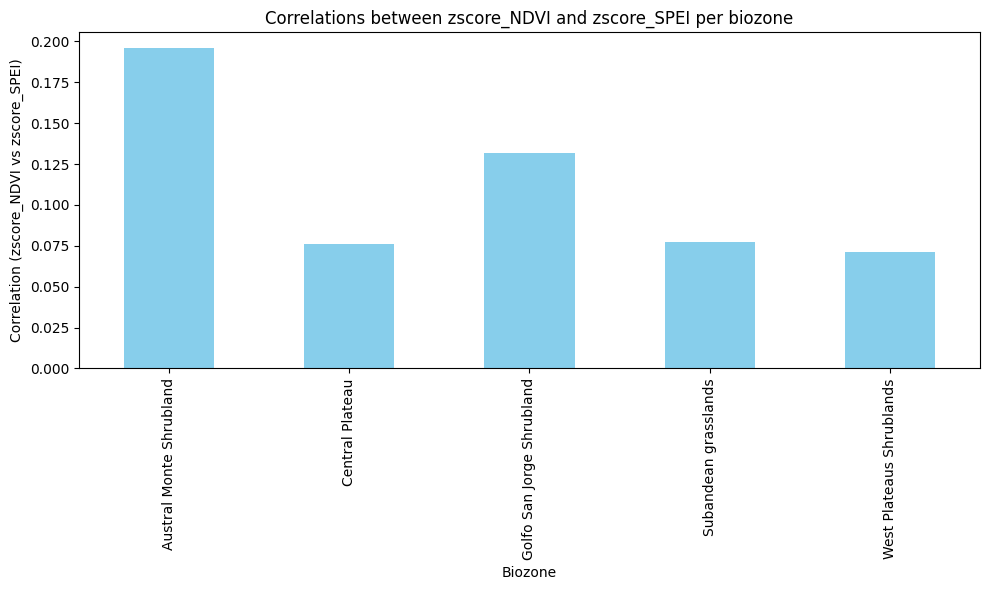

In [ ]:
# Step 1: Extract the year from 'year_month_datetime'
# Two_NDVI_SPEI_cluster_merged['year'] = Two_NDVI_SPEI_cluster_merged['year_month_datetime'].dt.year

# Step 2: Group by the 'cluster' column
# Step 3: Calculate the correlation between 'zscore_NDVI' and 'zscore_SPEI' for each year
correlations_by_biozone = NDVI_SPEI_MARAS_COR_BIOZONE.groupby('Biozone').apply(lambda x: x['zscore_NDVI'].corr(x['zscore_SPEI']))

# Display the correlations
# print(correlations_by_cluster)

# Step 3: Plot the correlations as a bar plot
correlations_by_biozone.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Step 4: Set the labels and title
plt.xlabel('Biozone')
plt.ylabel('Correlation (zscore_NDVI vs zscore_SPEI)')
plt.title('Correlations between zscore_NDVI and zscore_SPEI per biozone')

# Show the plot
plt.tight_layout()
plt.show()

## 5.5) Correlations by Altitude

In [ ]:
correlations_by_site_name = NDVI_SPEI_MARAS_COR_BIOZONE.groupby(['Site_Name', 'Altitude']).apply(
    lambda x: x['zscore_NDVI'].corr(x['zscore_SPEI'])
).reset_index(name='Correlation')

correlations_by_site_name

<ipython-input-39-2e4385499c06>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_by_site_name = NDVI_SPEI_MARAS_COR_BIOZONE.groupby(['Site_Name', 'Altitude']).apply(


,Site_Name,Altitude,Correlation
0,1 San Felipe,332,0.091506
1,2 San Felipe,334,0.135269
2,Aguada Amarga,214,0.382235
3,Arabia Saudita,955,0.001720
4,Arregui,620,0.144911
...,...,...,...
72,Quichaura,811,-0.033187
73,Seis Hermanos,771,-0.064078
74,Telleriarte,973,0.099818
75,Tureo,654,0.124853


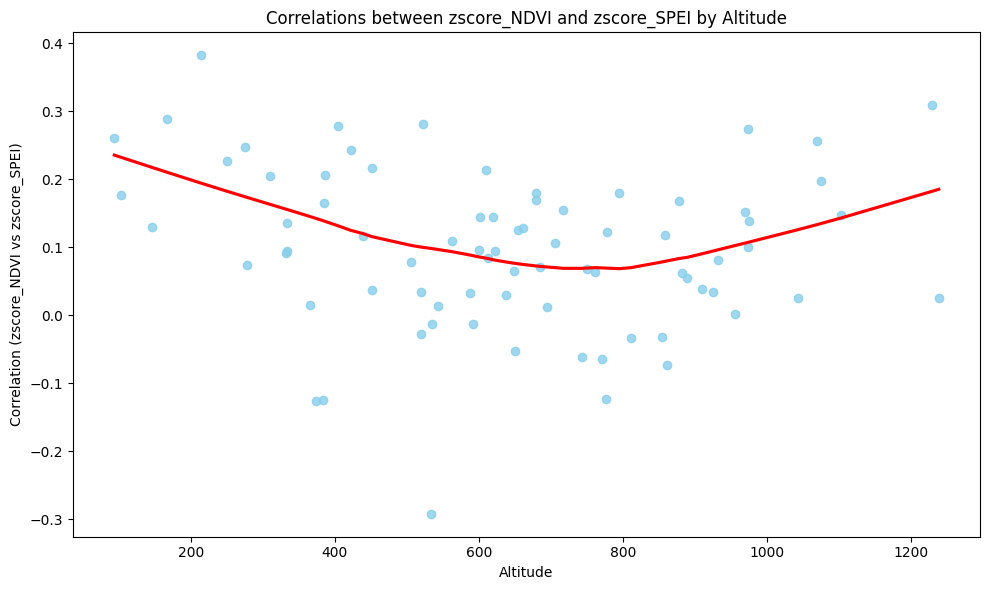

In [ ]:
# Create a scatter plot with a smooth trendline
plt.figure(figsize=(10, 6))
sns.regplot(x='Altitude', y='Correlation', data=correlations_by_site_name, scatter_kws={'color':'skyblue'}, line_kws={'color':'red'}, lowess=True)

# Set the labels and title
plt.xlabel('Altitude')
plt.ylabel('Correlation (zscore_NDVI vs zscore_SPEI)')
plt.title('Correlations between zscore_NDVI and zscore_SPEI by Altitude')

# Show the plot
plt.tight_layout()
plt.show()


# 6.) Subandean grasslands

## 6.1) Extract only months of dry period and Subandean grassland

In [ ]:
# Extract months from the year_month column
NDVI_SPEI_MARAS_Biozone['month'] = NDVI_SPEI_MARAS_Biozone['year_month'].str[-2:].astype(int)

# Filter the data for Biozone "Subandean grasslands" and months December (12), January (01), February (02), and March (03)
NDVI_SPEI_MARAS_Subandean = NDVI_SPEI_MARAS_Biozone[
    (NDVI_SPEI_MARAS_Biozone['Biozone'] == 'Subandean grasslands') &
    (NDVI_SPEI_MARAS_Biozone['month'].isin([12, 1, 2, 3]))
]

# Display the filtered data
NDVI_SPEI_MARAS_Subandean

,year_month,Biozone,NDVI,SPEI,month
3,2000_01,Subandean grasslands,0.07335,-0.169275,1
8,2000_02,Subandean grasslands,0.07355,0.012208,2
13,2000_03,Subandean grasslands,0.06925,-0.370350,3
58,2000_12,Subandean grasslands,0.07640,0.767023,12
63,2001_01,Subandean grasslands,0.08720,1.482244,1
...,...,...,...,...,...
1308,2021_12,Subandean grasslands,0.09160,-1.659922,12
1313,2022_01,Subandean grasslands,0.08910,-0.455261,1
1318,2022_02,Subandean grasslands,0.08595,-0.031783,2
1323,2022_03,Subandean grasslands,0.08655,0.302431,3


## 6.2) Calculate monthly correlations

In [ ]:
# Group by 'year_month' and calculate the correlation between 'SPEI' and 'NDVI' for each group
correlations = NDVI_SPEI_MARAS_Subandean.groupby(['year_month']).apply(lambda x: x['SPEI'].corr(x['NDVI']))

# Convert the result to a DataFrame and reset the index
correlations = correlations.reset_index()
correlations.columns = ['year_month', 'Correlation']

# Merge the correlation results back into the original DataFrame on 'year_month'
NDVI_SPEI_Subandean_COR = NDVI_SPEI_MARAS_Subandean.merge(correlations, on='year_month', how='left')

# Display the DataFrame with the new 'Correlation' column
NDVI_SPEI_Subandean_COR

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-42-ed2cda6696fa>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = NDVI_SPEI_MARAS_Subandean.groupby(['year_month']).apply(lambda x: x['SPEI'].corr(x['NDVI']))


,year_month,Biozone,NDVI,SPEI,month,Correlation
0,2000_01,Subandean grasslands,0.07335,-0.169275,1,NaN
1,2000_02,Subandean grasslands,0.07355,0.012208,2,NaN
2,2000_03,Subandean grasslands,0.06925,-0.370350,3,NaN
3,2000_12,Subandean grasslands,0.07640,0.767023,12,NaN
4,2001_01,Subandean grasslands,0.08720,1.482244,1,NaN
...,...,...,...,...,...,...
87,2021_12,Subandean grasslands,0.09160,-1.659922,12,NaN
88,2022_01,Subandean grasslands,0.08910,-0.455261,1,NaN
89,2022_02,Subandean grasslands,0.08595,-0.031783,2,NaN
90,2022_03,Subandean grasslands,0.08655,0.302431,3,NaN


## 6.3) Plot

In [ ]:
# Ensure year_month is treated as a categorical string
NDVI_SPEI_MARAS_COR_SUBANDEAN['year_month'] = NDVI_SPEI_MARAS_COR_SUBANDEAN['year_month'].astype(str)

# Format the 'year_month' to only show year and month, in case it's being treated as a date
NDVI_SPEI_MARAS_COR_SUBANDEAN['year_month'] = NDVI_SPEI_MARAS_COR_SUBANDEAN['year_month'].str[:7]

# Create a color column based on SPEI values
NDVI_SPEI_MARAS_COR_SUBANDEAN['color'] = NDVI_SPEI_MARAS_COR_SUBANDEAN['SPEI'].apply(lambda x: 'blue' if x > 0 else 'red')

# Initialize the figure and the first axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot SPEI bars with align='edge' to align left edge of the bar with the x-tick
ax1.bar(
    NDVI_SPEI_MARAS_COR_SUBANDEAN['year_month'],
    NDVI_SPEI_MARAS_COR_SUBANDEAN['SPEI'],
    color=NDVI_SPEI_MARAS_COR_SUBANDEAN['color'],
    align='edge',  # Align bars to the left edge of each tick
    width=0.8      # Adjust the width of the bars for better spacing
)

# Set x-axis to treat 'year_month' as categories
ax1.set_xticks(NDVI_SPEI_MARAS_COR_SUBANDEAN['year_month'])
ax1.set_xticklabels(NDVI_SPEI_MARAS_COR_SUBANDEAN['year_month'], rotation=90)

# Setting labels and title for the first axis (SPEI)
ax1.set_xlabel('Year_Month')
ax1.set_ylabel('SPEI', color='black')
ax1.set_title('SPEI and NDVI Values for Subandean grassland')

# Create a second y-axis for NDVI values
ax2 = ax1.twinx()

# Plot NDVI as black dots connected with a line
ax2.plot(
    NDVI_SPEI_MARAS_COR_SUBANDEAN['year_month'],
    NDVI_SPEI_MARAS_COR_SUBANDEAN['NDVI'],
    color='black',
    marker='o',
    linestyle='-',
    label='NDVI'
)

# Set labels for the second y-axis (NDVI)
ax2.set_ylabel('NDVI', color='black')

# Adding a grey box for every second dry season (December to March of the next year)
# First, get the indices where the dry seasons occur
dry_seasons = []
for i in range(len(NDVI_SPEI_MARAS_COR_SUBANDEAN)):
    if NDVI_SPEI_MARAS_COR_SUBANDEAN.iloc[i]['month'] == 12:
        dry_seasons.append(i)  # Store the index of December

# Now highlight every second dry season
for i in range(0, len(dry_seasons), 2):
    start = dry_seasons[i]
    end = min(start + 4, len(NDVI_SPEI_MARAS_COR_SUBANDEAN) - 1)  # 4 months from Dec to March
    ax1.axvspan(NDVI_SPEI_MARAS_COR_SUBANDEAN['year_month'].iloc[start],
                NDVI_SPEI_MARAS_COR_SUBANDEAN['year_month'].iloc[end],
                color='lightgrey', alpha=0.5)

# Show the plot with tight layout
plt.tight_layout()
plt.show()


NameError: name 'NDVI_SPEI_MARAS_COR_SUBANDEAN' is not defined